https://github.com/BenJMcCarty/Phase_2_Project_Final

# Selling Seattle: Impactful Features on House Sell Price 

**When selling your house, one of the highest priorities is getting the best price for it.** You may be a real estate agent looking to advise homeowners on the price range for their home, or to give potential buyers an idea of what prices to expect for particular features (like waterfront locations or multiple bedrooms). Or perhaps you are a homeowner who is interested in doing some renovations to improve the house's value. Either way, you want to know what features have the greatest impact on that value.

But how do you *really* know what features are best? How can you be sure that your intuition or expectations are based on fact and not assumptions? **Turn to the facts for answers!**

---

**WHAT QUESTIONS ARE IMPORTANT FROM THE BUSINESS PERSPECTIVE? WHAT QUESTIONS DID I USE TO GUIDE MY EXPLORATION?**

My project used data from house sales in King County, WA. to determine some of the top features determining the sell price of a home.

* **First, I explored the data using the Pandas package to review the data itself.** I reviewed the different features included in my dataset and their respective values; the descriptive statistics for the numerical data; and the overall size and shape of the data (how many rows and columns).

* **Then, I used Seaborn to plot the data and a fitted linear regression model for each feature against the sell price.** These visualizations helped differentiate which features to treat as *categorical* variables (e.g. features that would be one of a select number of options) versus *continuous* variables (which would have less of a rigid range of values).

* **In order to give more depth to my data, I engineered four new features based on the original features and data.** I determined the age of each house at sale; whether or not a home was renovated; how many years since a renovation; and whether or not a house had a basement.

* **I wanted to make sure all of the features and their data were relevant to apply to my future model.** I performed correlational comparisons to determine which features were too closely related (indicating multicollinearity), which would affect my modeling process later on.

* **To test my assumptions that certain features would have a statistically significant impact on the price, I performed a few statistical tests.** I performed an ANOVA test on our "condition" feature (comparing each ranking of condition against the others) and I ran a two-sample t-test on the "waterfront" and "was_renovated" features as well.

* **LReg for Inferences**

# ** Setting Up the Tools and Data**

## Imports

In [1]:
# Data Handling
import pandas as pd
import numpy as np
from scipy import stats
import plotly.express as px

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling - Statsmodels
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import statsmodels.api as sms

# Modeling - SKLearn
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import RFECV

# Settings
%matplotlib inline
plt.style.use('seaborn-talk')
pd.set_option('display.max_columns', None)

## Defining Functions

I created several functions to help review, clean, test, and evaluate my data.

### Data Cleaning and Visualizations

> The following functions enable the user to filter a Pandas series and return a boolean index to use for filtering out the outliers. Once saved to a new variable, the user can perform further filtering by using the new variable to slice the dataframe to be filtered.

#### ƒ: `find_outliers_z`

In [2]:
## Check using z-score - sensitive to outliers

def find_outliers_z(data):
    """Detects outliers using the Z-score>3 cutoff.
    Returns a boolean Series where True=outlier
    
    Source: https://github.com/jirvingphd/dsc-phase-2-project/blob/main/functions_SG.py
    """
    
    zFP = np.abs(stats.zscore(data))
    zFP = pd.Series(zFP, index=data.index)
    idx_outliers = zFP > 3
    return idx_outliers

#### ƒ: `find_outliers_IQR`

In [3]:
## Check using IQR - less sensitive to outliers

def find_outliers_IQR(data):
    """
    * Takes a series sliced from a dataframe
    * Detects outliers using the 1.5*IQR thresholds.
    * Returns a boolean Series where True=outlier

    Source: https://github.com/jirvingphd/dsc-phase-2-project/blob/main/functions_SG.py
    """
    
    res = data.describe()
    q1 = res['25%']
    q3 = res['75%']
    thresh = 1.5*(q3-q1)
    idx_outliers =(data < (q1-thresh)) | (data > (q3+thresh))
    return idx_outliers

#### ƒ: `feature_vis`

In [4]:
def feature_vis(data, x, y = 'price', discrete = False, kde = True):
    '''-----
    * Requires a DataFrame and a column name to process.
    * Keyword arguments specify that the target variable will be "price"
    for this case.
    * For future use, redefine function without predetermined y-value, or 
    reassign.
    
    --
    
    * Args:
        * Data: Pandas DataFrame; data source
        * x: str; column index to specify data
    
    * Kwargs:
        * y = "price"
        * discrete = False
        * kde = true
        
    -----'''
    
    ## Print the slice of the original DataFrame for easy viewing
    
    print(df[x].value_counts().sort_index())
  
    ## Create two plots via Seaborn: one scatter plot with regression line,
    ## then a histogram of the data (with KDE if specified
    
    fig, axs = plt.subplots(ncols=2, figsize= (12,6))
    
    sns.regplot(data=data, x=x, y=y, ax=axs[0])
    sns.histplot(data=data, x=x, discrete=discrete, kde=kde, ax=axs[1])
    
    fig.suptitle(f'{x.title()} vs. {y.title()}', fontsize=16)
    plt.tight_layout();
    
    return

#### ƒ: `filter_outliers`

In [5]:
def filter_outliers(data):
    '''------
    
    * Removes outliers from data via "find_outliers_IQR" and saves filtered
    values to the dataframe
    
    ---
    
    * Arg:
        * Data: slice of a dataframe for a specific column header
    
    ------
    '''
   
    idx_out = find_outliers_IQR(data)
 
    cleaned = df[~idx_out]

    print(f'There were {idx_out.sum()} outliers.')
    
    return cleaned

#### ƒ: `remove_outliers`

In [6]:
def remove_outliers(data, x):

    idx_out = find_outliers_IQR(data[x])
 
    df_clean = df[~idx_out].copy()
    
    return df_clean

#### ƒ: `show_cleaned_vis`

In [7]:
def show_cleaned_vis(data, x, y = 'price', discrete = False, kde = True):
    '''-----
    
    * Combines functions to filter outliers and to create the feature 
        visualizations.
    * Requres 'find_outliers_IQR' and 'feature_vis' to be defined.
    * Returns filtered data and two visualizations - Seaborn regression plot
        and histplot.
    
    ---
    
    * Args:
        * Data: Pandas DataFrame; data source
        * x: str; column index to specify data
    * Kwargs
    
    -----'''
    
    ### Filter outliers first
    
    idx_out = find_outliers_IQR(data[x])
 
    df_cleaned = df[~idx_out].copy()

    print(f'There were {idx_out.sum()} outliers.')
    
    ### Plot Data
    
    
    df_cleaned[x].value_counts().sort_index()
        
    fig, axs = plt.subplots(ncols=2, figsize= (12,6))
    
    sns.regplot(data=df_cleaned, x=x, y=y, ax=axs[0])
    sns.histplot(data=df_cleaned, x=x, discrete=discrete, kde=kde, ax=axs[1])
    
    fig.suptitle(f'{x.title()} vs. {y.title()}', fontsize=16)
    plt.tight_layout();
    
    return #df_cleaned

### Creating Function for T-Testing

#### ƒ: `ttest_review`

In [8]:
def ttest_review(sample_1, sample_2, alpha=.05):
    '''------
    * Runs a t-test on two samples; prints whether or not they are significant,
    and returns p-value as a variable called "p-value."
    * Requires two data samples and an alpha value.
    
    ----
    
    * Args: two data samples for t-test
    * Kwargs: alpha=.05
    
    -----
    '''
    
    result = stats.ttest_ind(sample_1, sample_2)
    crit_val, p_val = result
    
    ## Creating interpretation based on p-value results.

    if p_value < .05:
        print(f'The feature "waterfront" is statistically significant with a p-value of {p_val}.')

    else:
         print(f'The feature "waterfront" is not statistically significant with a p-value of {p_val}.')
    
    return p_val

### Creating a Correlation Matrix

#### ƒ: `"corr_val"`

In [9]:
# Create "corr_val" function

def corr_val(df,figsize=(15,15),cmap="OrRd",):
    
    # Calculate correlations
    corr = df.corr()
       
    # Create a mask of the same size as our correlation data
    mask = np.zeros_like(corr)
    
    # Set the upper values of the numpy array to "True" to ignore them
    mask[np.triu_indices_from(mask)] = True

    fig, ax = plt.subplots(figsize=figsize)
    
    # Mask=mask to hide the upper-right half of values (otherwise mirrored)
    sns.heatmap(corr, annot=True,cmap="Reds",mask=mask)
    return fig, ax

### Creating and Evaluating Models

#### ƒ: `create_model`

In [10]:
def create_model(data, cont, cat):
    '''------
    
    * Creates a linear regression model using Statsmodels OLS
    * Save the 
    
    ---
    
    * Args:
        * Data: dataframe as data source
        * Cont: list of continuous variables
        * Cat: list of categorical variables
        * unique_id: UNIQUE name for the resulting model
    
    -----
    '''

    cont_features = '+'.join(cont)

    cat_features = '+'.join([f'C({x})' for x in cat])

    f = f'price~+{cont_features}+{cat_features}'

    print(f)

    model = smf.ols(formula=f, data=data).fit()
   
    diagnose_model(model)
    
    return model

#### ƒ: `diagnose_model`

>* Create a function to:
>  * Display the summary details of the model
>  * Create a scatter plot of the predictions
>    * Used for determining homoscedasticity
>  * Create a Q-Q plot of the residuals of the model
>    * Used to determine the normality of the residuals


In [11]:
def diagnose_model(model, figsize=(10,5)):
    """ ---
    
    Argument:
        * model: provide the linear regression model for diagnostics
    
    Keyword Argument:
        * figsize: default (10,5); can increase/decrease for larger/smaller
    ---
    
    * Display the summary details of the provided model
    * Create two scatter plots to test assumptions of linearity
        * Predictions: verifying homoscedasticity (no cone-shapes)
        * Residuals: confirming normal distribution of residuals
    ---
    
    """
    display(model.summary())
    
    fig, axes = plt.subplots(ncols=2, figsize=figsize)

    axes[0].scatter(model.predict(), model.resid)
    axes[0].axhline()
    axes[0].set_xlabel('Model Predictions')
    axes[0].set_ylabel('Model Residuals')
    axes[0].set_title('Testing for Homoscedasticity')

    sms.graphics.qqplot(data=model.resid, fit=True, line = "45", ax=axes[1])
    
    plt.tight_layout()
    
    return

#### ƒ: `plot_param_coef`

>* Create a function to:
>  * Get the model's coefficients as a series
>  * Plot a figure to show the coefficients in descending order


In [12]:
def plot_param_coef(model, kind = 'barh', figsize = (10,5)):
    ''' ---
    
    * Plotting a figure to visualize parameter coefficients
    
    ---
    
    * Args:
        * Model: linear regression model details to plot
        
    * Kwargs:
        * Kind (default 'barh'): allows different types of plots
        * Size (default (10,10)): allows for different sizes
    ---
    
    '''
    # Plotting figure to visualize parameter coefficients

    ## Getting coefficients as a Series
    params = model.params[1:]
    params.sort_values(inplace=True)

    plt.figure(figsize=figsize) # Used if large number of params
    ax = params.plot(kind=kind)
    ax.axvline()
    ax.set_xlabel('Coefficient')
    ax.set_ylabel('Features')
    ax.set_title('Comparing Feature Coefficients')
    
    plt.tight_layout()
    
    return

#### ƒ: `plot_p_values`

In [13]:
def plot_p_values(model, kind = 'barh', size = None, alpha = .05):
    ''' ---
    
    * Plots a figure to visualize parameter p-values exceeding stated alpha.
    
    ---
    
    * Args:
        * Model: linear regression model details to plot
        
    * Kwargs:
        * Kind (default 'barh'): allows different types of plots
        * Size (default None): allows for different sizes
    ---
    
    '''
    
    pv = model.pvalues[1:]
    pv_high = pv[pv > alpha]
    pv_low = pv[pv <= alpha]
    pv_high.sort_values(ascending=False, inplace=True)
    
    if len(pv_high) > 0:
        plt.figure(figsize=size) # Used if large number of params
        ax = pv_high.plot(kind=kind)
        ax = pv_low.plot(kind=kind)
        ax.axvline()
        plt.suptitle(f'P-Values')
        
    if len(pv_low) > 0:
        plt.figure(figsize=size) # Used if large number of params
        ax = pv_low.plot(kind=kind)
        ax.axvline()
        plt.suptitle(f'P-Values Below {alpha}')        
        
#     else:
#         print(f'There are no p-values above {alpha}.')
        
    plt.tight_layout()
    
    return

#### ƒ: `review_model`

In [14]:
def review_model(model):
    '''---
    
    Combines earlier functions into one all-purpose function for reviewing
    model performance.
    
    ---
    
    Arg:
        * model: Specify model to review.
        
    ---'''
    
    diagnose_model(model)
    
    plot_param_coef(model)
    
    plot_p_values(model)
    
    return    

## Reading Data

In [15]:
df= pd.read_csv('https://raw.githubusercontent.com/BenJMcCarty/Phase_2_Project_Final/main/kc_house_data_train.csv', index_col=0)

# **Exploring Fresh Data**

## Basic Overviews

The goal for this section is to get a broad idea of the data before I start any cleaning or feature engineering.

In [16]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17290 entries, 0 to 17289
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             17290 non-null  int64  
 1   date           17290 non-null  object 
 2   price          17290 non-null  float64
 3   bedrooms       17290 non-null  int64  
 4   bathrooms      17290 non-null  float64
 5   sqft_living    17290 non-null  int64  
 6   sqft_lot       17290 non-null  int64  
 7   floors         17290 non-null  float64
 8   waterfront     17290 non-null  int64  
 9   view           17290 non-null  int64  
 10  condition      17290 non-null  int64  
 11  grade          17290 non-null  int64  
 12  sqft_above     17290 non-null  int64  
 13  sqft_basement  17290 non-null  int64  
 14  yr_built       17290 non-null  int64  
 15  yr_renovated   17290 non-null  int64  
 16  zipcode        17290 non-null  int64  
 17  lat            17290 non-null  float64
 18  long  

**DF Columns to Convert**

I could convert the 'date' feature datatype from object to datetime or I may drop it instead.

In [18]:
df.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [19]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,1.729000e+04,1.729000e+04,17290.000000,17290.000000,17290.000000,1.729000e+04,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000
mean,4.565502e+09,5.407395e+05,3.372470,2.111943,2081.464604,1.524340e+04,1.490312,0.007981,0.238519,3.408502,7.654425,1789.306015,292.158589,1970.792019,83.806304,98078.193175,47.560058,-122.214258,1987.986698,12873.475824
std,2.874656e+09,3.733190e+05,0.939346,0.770476,920.018539,4.230462e+04,0.538909,0.088985,0.775229,0.651296,1.174718,829.265107,443.151874,29.343516,400.329376,53.607949,0.138412,0.140857,684.802635,27227.437583
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.720000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,659.000000
25%,2.114701e+09,3.210000e+05,3.000000,1.500000,1430.000000,5.081250e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1951.000000,0.000000,98033.000000,47.471200,-122.329000,1490.000000,5111.250000
50%,3.903650e+09,4.500000e+05,3.000000,2.250000,1920.000000,7.642000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1974.000000,0.000000,98065.000000,47.571600,-122.230000,1840.000000,7622.500000
75%,7.301150e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.072575e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2214.500000,560.000000,1996.000000,0.000000,98118.000000,47.677900,-122.126000,2360.000000,10101.750000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,858132.000000


### Overview Summary

The dataset contains 21 colums of data, most of which seem useful for evaluations and modeling, but "id" and "date" are not really usable in their current state.

I do not have any null values to handle. Additionally, the data types seem to be relatively accurate; the only exception being the dates being treated as an object vs. datetime.

I could convert the date for later calculations, engineering, or modeling. For now, I will leave it as-is.

## Exploring Features

Now I will be comparing each individual feature against "price" to determine if a feature is continuous or categorical.

I will check the regressions and histograms for each feature; if a regression plot shows a flatter regression line or if the histogram is not a normal distribution, I will treat that feature as a categorical feature.

As part of the function to create the plots, I include my function to ignore any outliers for the purpose of the visualizations. I will *not* change the data itself, though.

### Bedrooms

There were 451 outliers.


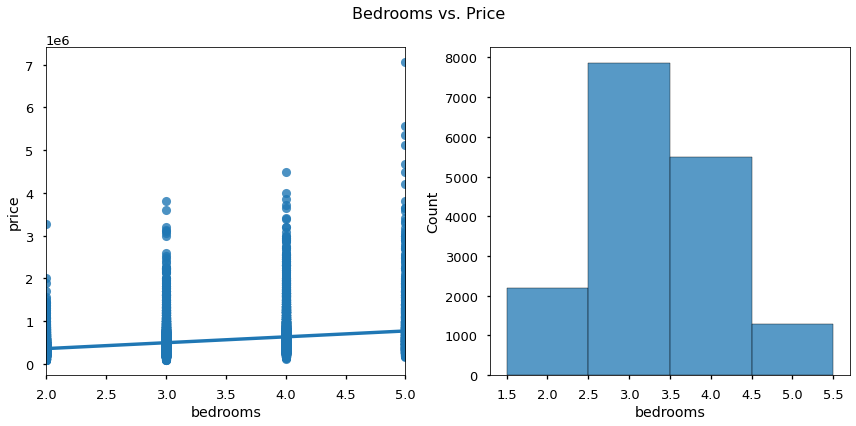

In [20]:
show_cleaned_vis(df,"bedrooms", discrete=True, kde = False)

***
**Observations**
>* There is a slight linear regression between the number of bedrooms and the sell price, indicated by the positive slope of the regression line.
>
>* The histogram slightly resembles a normal distribution, although the first bin is lower than I would expect for a normal distribution.

***
**TO-DO**
>* Use Bedrooms as a continuous variable.
***

### Bathrooms

There were 209 outliers.


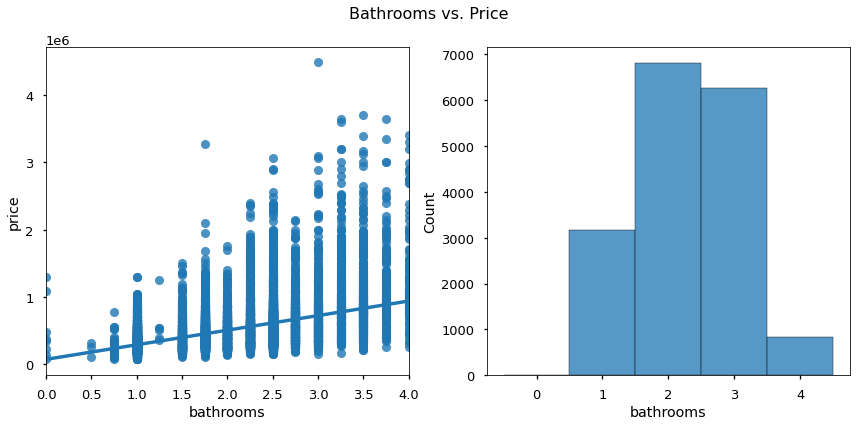

In [21]:
show_cleaned_vis(df,"bathrooms", discrete=True, kde=False)

***
**Observations**
>* Clear linear relationship between bathrooms and price.
>* The histogram/normal distribution isn't the strongest, but I feel it is good enough.
***
**TO-DO**
>* Use as continuous variable.
*** 

### sqft_living

There were 454 outliers.


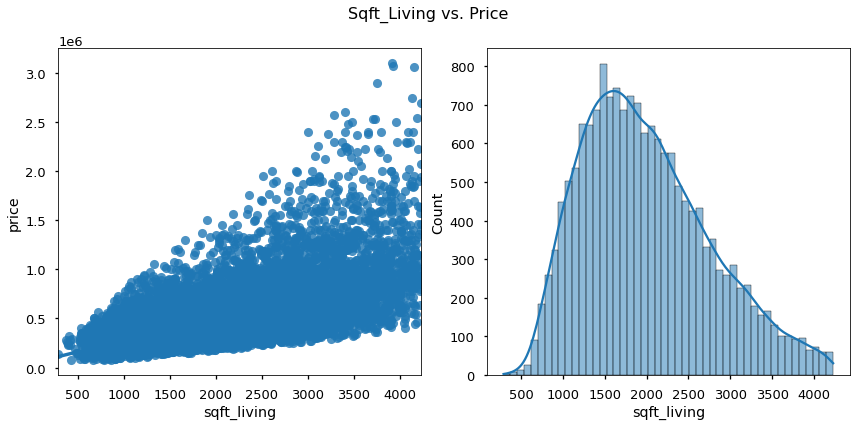

In [22]:
show_cleaned_vis(df,"sqft_living")

***
**Observations**

>* Clear linear relationship and normal distribution.

***

**TO-DO**

>* Use as continuous variable


### sqft_lot

There were 1963 outliers.


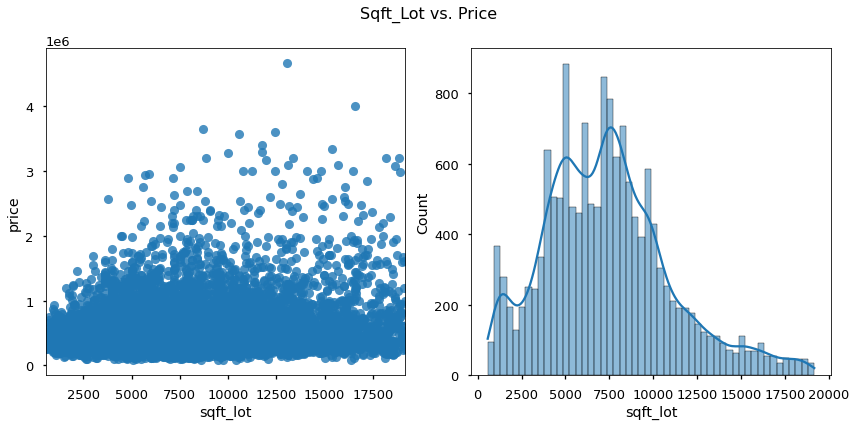

In [23]:
show_cleaned_vis(df,"sqft_lot")

***
**Observations**

>* Neither normally distributed nor having a linear relationship with price.
***

**TO-DO**

>* Treat as categorical variable.

* **

### floors

There were 0 outliers.


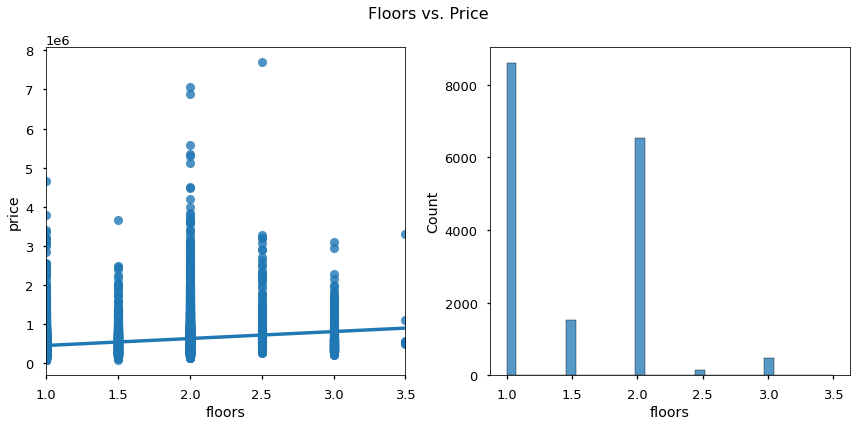

In [24]:
show_cleaned_vis(df,"floors", kde=False)

***
**Observations**

>* Linear relationship, but not normally distributed
>
>* Most homes had one or two bedrooms.

***
**TO-DO**

>* Treat as continuous variable due to regression
 
***

### waterfront

0    17152
1      138
Name: waterfront, dtype: int64


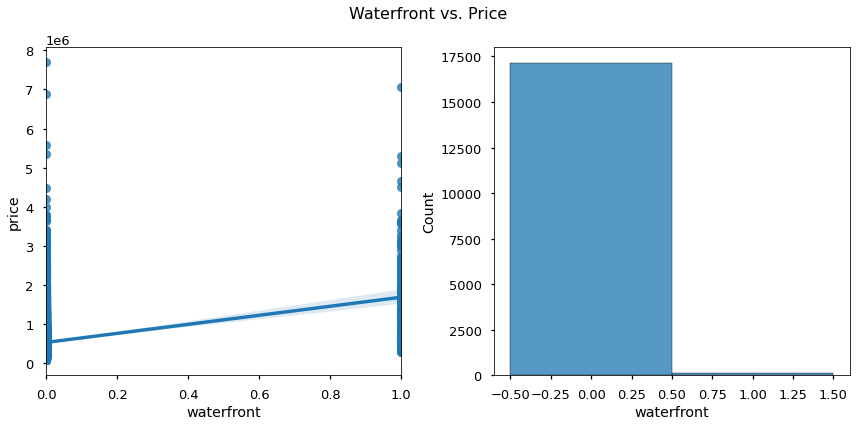

In [25]:
feature_vis(df,"waterfront", discrete=True, kde=False)

***
**Observations**

>* Graphs are misleading
>* Most properties are non-waterfront
>* Clear linear relationship, but not normally distributed

***
**TO-DO**

>* Treat as categorical - only two options (0 or 1).
 
***

### view

0    15571
1      264
2      775
3      410
4      270
Name: view, dtype: int64


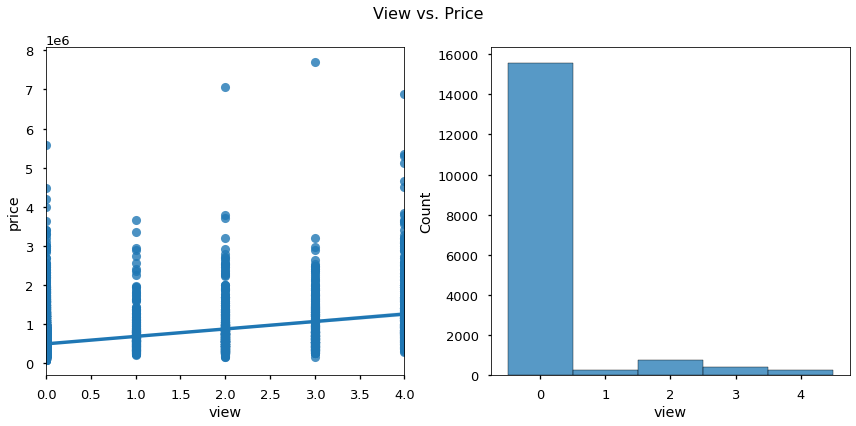

In [26]:
feature_vis(df,"view", discrete=True, kde=False)

***
**Observations**

>* Higher "view" rating, higher price
>* Most have '0' view
>* A few extreme outliers in pricing

***
**TO-DO**

>* Treat as categorical
 
***

### condition

There were 24 outliers.


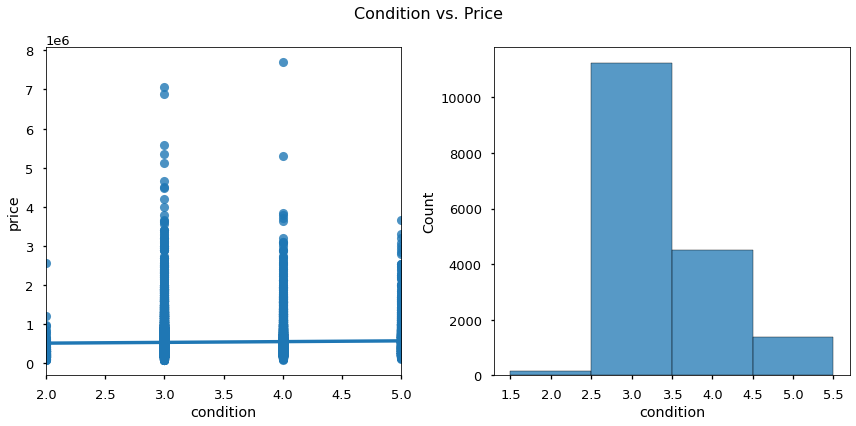

In [27]:
show_cleaned_vis(df,"condition", discrete=True, kde= False)

***
**Observations**

>* Largest number of homes sold were in condition 3
>* Very few sold in 1s, 2s
>* Price outliers in 4.0 area, some slight outliers in 2 and 3
>* No linear relationship, not normal distribution.

***
**TO-DO**

>* Treat as categorical
 
***

### grade

There were 1512 outliers.


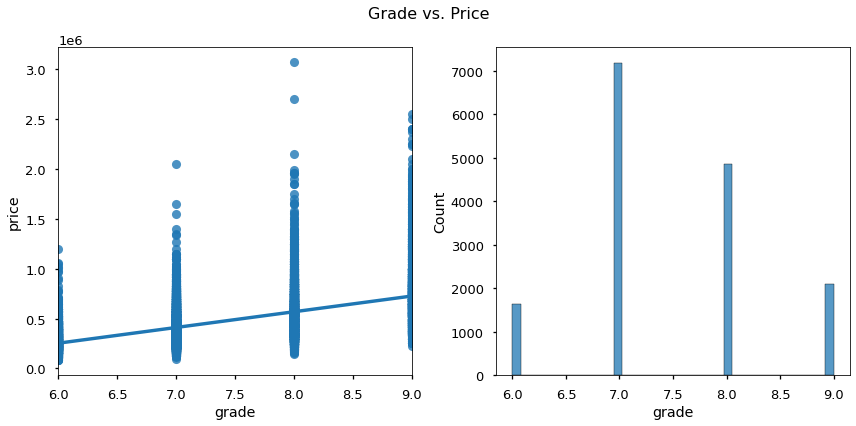

In [28]:
show_cleaned_vis(df,"grade", kde=False)

**Observations**

>* Clear linear trend - as grade increases, so does price
>
>* Largest range of grades is 6-9
---
**TO-DO**

>* Treat as continuous variable


### sqft_above

There were 498 outliers.


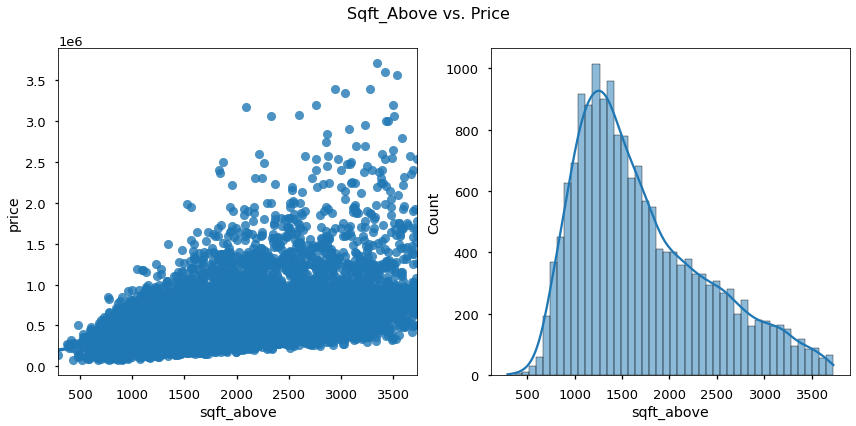

In [29]:
show_cleaned_vis(df,"sqft_above")

---

**Observations**

>* Outliers impacting accuracy of linear regression, but still seems relatively linear.
>
>* Distribution skewed left, but normal
---
**TO-DO**

>* Treat as continuous
---

### sqft_basement

There were 396 outliers.


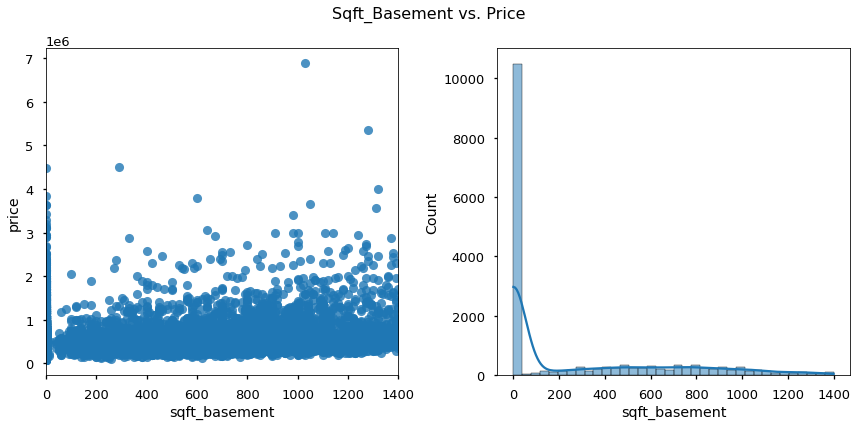

In [30]:
show_cleaned_vis(df,"sqft_basement")


**Observations**

>* Lots of 0 sqft basements -  shows no basement at all on property
>
>* scattered outliers; poor regression due to 0s
---
**TO-DO**

>* Treat as continuous if used for modeling


### yr_built

There were 0 outliers.


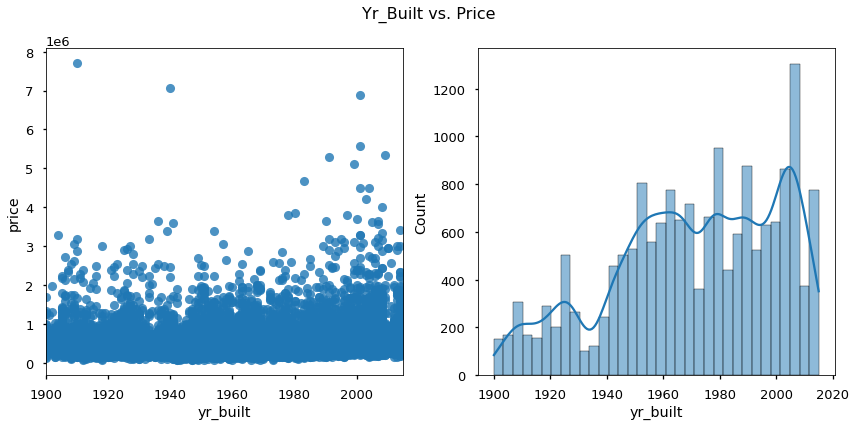

In [31]:
show_cleaned_vis(df,"yr_built")

---
**Observations**

>* Non-linear trend from this regression plot
>
>* Seems like may houses built between 1940 - 1970, then major boom in early 2000s.
>
>* Some significant outliers with price, but not affecting regression
---

**TO-DO**

>* Compare to year sold - how old was the house at sale?
>
>* Treat as categorical due to regression plot
---

### yr_renovated

0       16564
1934        1
1940        2
1944        1
1945        3
        ...  
2011        8
2012        9
2013       30
2014       71
2015       12
Name: yr_renovated, Length: 69, dtype: int64


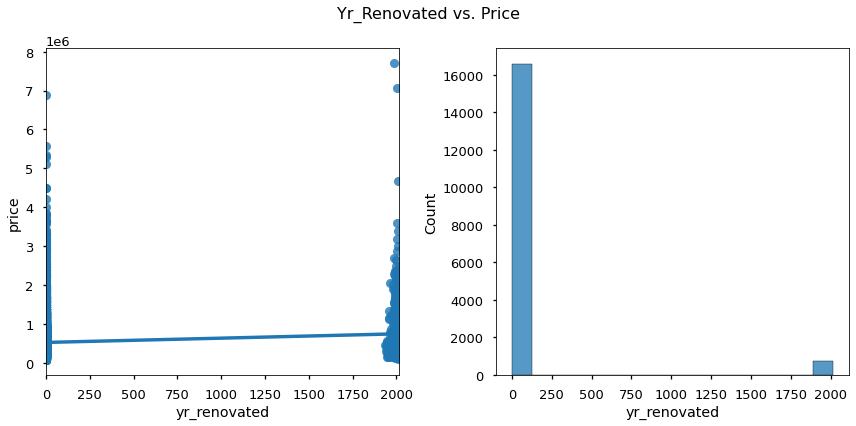

In [32]:
feature_vis(df,'yr_renovated', kde=False)


**Observations**

>* Number of houses not renovated significantly outweighs the number renovated
>
>* Graphs indicate that an engineered feature for whether or not the house was renovated would be worthwhile.
---
**TO-DO**

>* Create new categorical feature - renovated or not

### zipcode

There were 0 outliers.


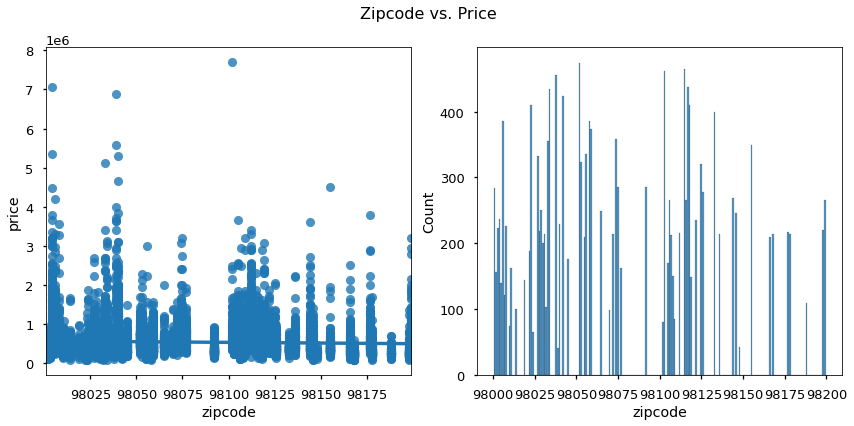

In [33]:
show_cleaned_vis(df,"zipcode", discrete=True, kde=False)

---
**Observations**

>* No linear relationship; not normally distributed
---
**TO-DO**

>* Treat as categorical variable
>
>* Perform OneHotEncoding to create new features for modeling.
---

### lat

There were 1 outliers.


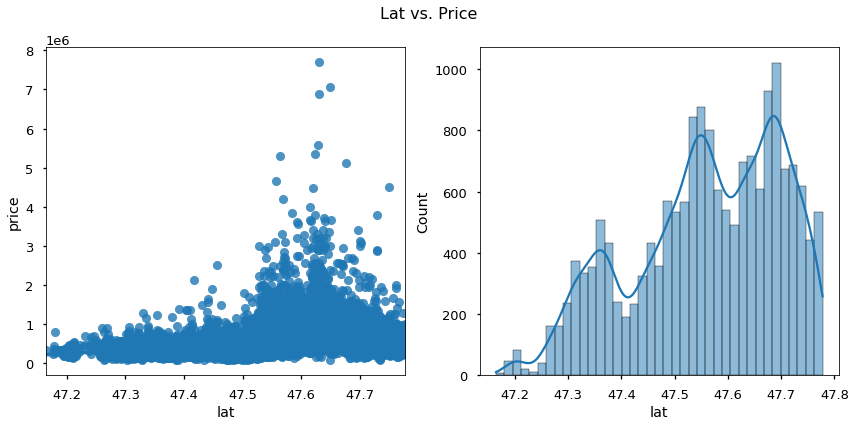

In [34]:
show_cleaned_vis(df,"lat")

**Observations**

>* No linear relationship and not normally distributed.

---
**TO-DO**

>* Treat as continuous if used for modeling.

### long

There were 206 outliers.


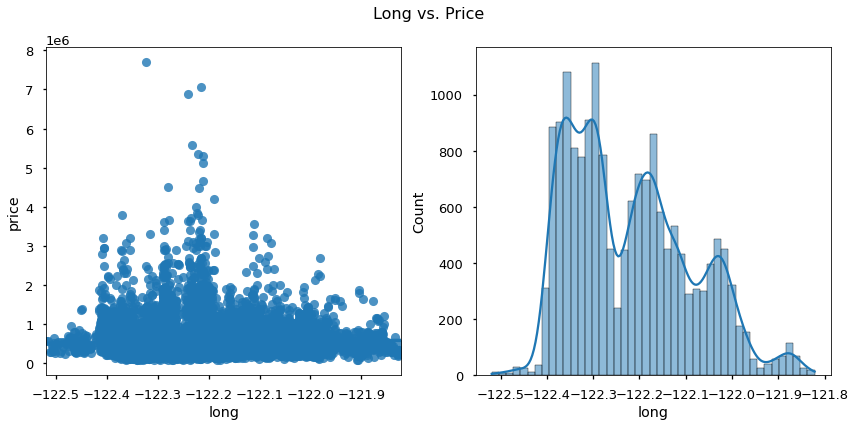

In [35]:
show_cleaned_vis(df,"long")

**Observations**

>* No linear relationship and not normally distributed.

---
**TO-DO**

>* Treat as continuous if used for modeling.

### sqft_living15

There were 438 outliers.


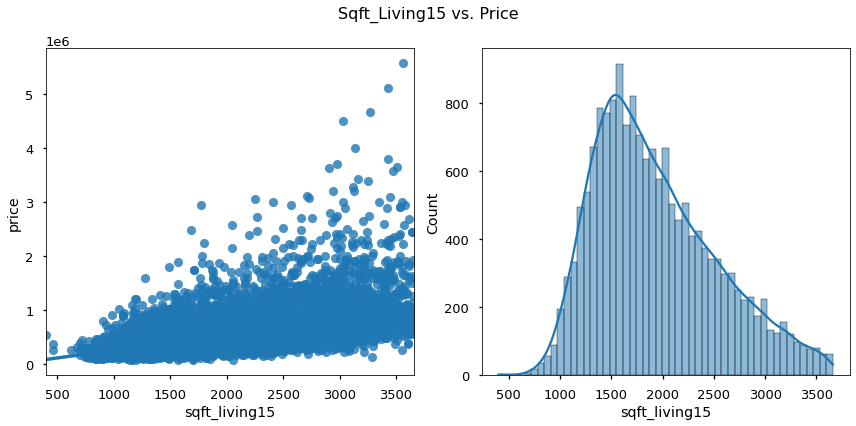

In [36]:
show_cleaned_vis(df,"sqft_living15")

---
**Observations**

>* Most properties sold with sqft between 1500/2000 
>
>* Price follows linear trend and is normally distributed, although skewed right.
---
**TO-DO**

>* Treat as continuous variable
---

### sqft_lot15

There were 1765 outliers.


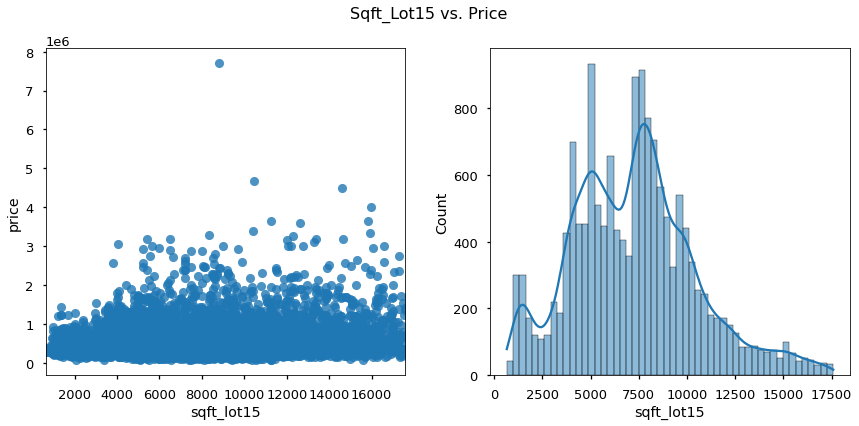

In [37]:
show_cleaned_vis(df,"sqft_lot15")

---
**Observations**

>* No clear linear trend

---
**TO-DO**
>* Treat as categorical
---

# **Feature Engineering**

## Creating `'yrs_old_sold'`

I created this feature to differentiate between houses that were built recently versus older houses.

In order to determine this feature, I need to determine the year the house was sold first.

### Determine `'year_sold'`

In [38]:
## Pull the year from the "date" column
df['year_sold'] = df['date'].map(lambda x: x[:4])

## Change it from a string to an integer datatype
df['year_sold'] =  df['year_sold'].map(lambda x: int(x))

In [39]:
## Confirm that it was created
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'year_sold'],
      dtype='object')

In [40]:
## Review the values to ensure they are only the four-digit years
df['year_sold'].value_counts()

2014    11703
2015     5587
Name: year_sold, dtype: int64

### Calculate `'y_old_sold'`

In [41]:
## Calculating the age of the house at the time of sale
df['y_old_sold'] = df['year_sold'] - df['yr_built']
df['y_old_sold'].describe()

## Minimum age is -1 due to a house being sold before it was finished being built

count    17290.000000
mean        43.531116
std         29.345345
min         -1.000000
25%         18.000000
50%         40.000000
75%         63.000000
max        115.000000
Name: y_old_sold, dtype: float64

In [42]:
## Confirming creation
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'year_sold',
       'y_old_sold'],
      dtype='object')

In [43]:
## Confirming number of house entries
df['y_old_sold'].value_counts().sort_index()

-1        7
 0      350
 1      232
 2      141
 3      123
       ... 
 111     41
 112     24
 113     23
 114     55
 115     22
Name: y_old_sold, Length: 117, dtype: int64

In [44]:
## Reviewing the descriptive stats for the data
df['y_old_sold'].describe()

count    17290.000000
mean        43.531116
std         29.345345
min         -1.000000
25%         18.000000
50%         40.000000
75%         63.000000
max        115.000000
Name: y_old_sold, dtype: float64

## `'was_renovated'`

I created this feature to determine whether or not a house was renovated. If a house was renovated, what impact would that have on the price? 

In [45]:
## Using the year that the home was renovated to deterine whether or not the home was renovated
reno_y_n = np.where(df['yr_renovated']>0, 1, 0 )
df = df.assign(was_renovated = reno_y_n)

In [46]:
## Checking values
df['was_renovated'].value_counts()

0    16564
1      726
Name: was_renovated, dtype: int64

In [47]:
## Confirming column was created
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'year_sold', 'y_old_sold',
       'was_renovated'],
      dtype='object')

## `"yrs_since_reno"`

If a house was renovated, how long ago was the renovation? Would more newly-renovated houses increase price?

In [48]:
## Using new "was_renovated" feature to calculate how recently the house was renovated at the time of sale
reno = df[df['was_renovated'] == 1]

difference = reno['year_sold'] - reno['yr_renovated']

difference

11       17
33       31
67       25
186      29
227      29
         ..
17229    16
17235    10
17239    22
17248    20
17259    15
Length: 726, dtype: int64

In [49]:
## Confirming column creation within the dataframe
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'year_sold', 'y_old_sold',
       'was_renovated'],
      dtype='object')

In [50]:
## Ensuring there are no null values in the new feature and replacing any with zeroes
df = df.assign(yrs_since_reno = difference)

df['yrs_since_reno'].fillna(0, inplace=True)

df['yrs_since_reno'].isnull().sum()

df['yrs_since_reno'].describe()

## Minimum age is -1 due to a house being sold before it was finished being built

count    17290.000000
mean         0.772470
std          4.888679
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         80.000000
Name: yrs_since_reno, dtype: float64

## "`has_bsmnt`"

I noticed that there were fewer houses with a value for "sqft_basement" during my data exploration. I am curious if the presence or absence of a basement would have any impact.

In [51]:
## Determining whether or not a house has a basement based on the square footage
df['has_bsmnt'] = np.where(df['sqft_basement'] > 0, 1, 0)

# Reviewing the results
display(df['has_bsmnt'].describe(), df['has_bsmnt'].value_counts())

count    17290.000000
mean         0.393638
std          0.488570
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: has_bsmnt, dtype: float64

0    10484
1     6806
Name: has_bsmnt, dtype: int64

# **Correlations**

## Determining Correlations with Price

In [52]:
## Determining each feature's relationship with price

df_corr = df.drop(['price', 'id', 'lat','long'], axis=1).corrwith(df['price']).sort_values(ascending=False)
display(df_corr[0:5],df_corr[-6:-1])

sqft_living      0.703540
grade            0.666215
sqft_above       0.607760
sqft_living15    0.585567
bathrooms        0.524335
dtype: float64

yrs_since_reno    0.058501
yr_built          0.056450
condition         0.036099
year_sold        -0.002334
zipcode          -0.048958
dtype: float64

## Determining Multicollinearity

In [53]:
## Get the correlation matrix for the data (without the target)
corr = df.drop('price',axis=1).corr()
corr.round(2)

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,y_old_sold,was_renovated,yrs_since_reno,has_bsmnt
id,1.00,-0.00,0.00,-0.01,-0.13,0.02,0.00,0.01,-0.01,0.00,-0.01,-0.00,0.01,-0.02,-0.01,-0.00,0.02,-0.01,-0.14,0.01,-0.01,-0.02,-0.01,0.00
bedrooms,-0.00,1.00,0.51,0.57,0.03,0.17,-0.01,0.08,0.03,0.35,0.47,0.30,0.15,0.01,-0.15,-0.00,0.12,0.39,0.03,-0.01,-0.15,0.01,-0.01,0.16
bathrooms,0.00,0.51,1.00,0.76,0.09,0.50,0.07,0.19,-0.12,0.66,0.69,0.28,0.51,0.05,-0.20,0.02,0.22,0.57,0.09,-0.03,-0.51,0.05,-0.01,0.16
sqft_living,-0.01,0.57,0.76,1.00,0.17,0.36,0.11,0.28,-0.06,0.76,0.88,0.44,0.32,0.05,-0.20,0.05,0.23,0.76,0.18,-0.03,-0.32,0.05,0.01,0.20
sqft_lot,-0.13,0.03,0.09,0.17,1.00,-0.00,0.02,0.07,-0.01,0.11,0.18,0.01,0.05,0.00,-0.13,-0.08,0.23,0.14,0.70,0.00,-0.05,0.00,0.01,-0.04
floors,0.02,0.17,0.50,0.36,-0.00,1.00,0.03,0.03,-0.26,0.46,0.53,-0.25,0.48,0.01,-0.06,0.05,0.13,0.28,-0.01,-0.02,-0.48,0.01,-0.00,-0.26
waterfront,0.00,-0.01,0.07,0.11,0.02,0.03,1.00,0.41,0.01,0.09,0.08,0.08,-0.02,0.09,0.03,-0.01,-0.04,0.09,0.03,-0.00,0.02,0.09,0.10,0.04
view,0.01,0.08,0.19,0.28,0.07,0.03,0.41,1.00,0.05,0.25,0.16,0.28,-0.05,0.09,0.09,0.00,-0.08,0.28,0.07,0.00,0.05,0.09,0.08,0.19
condition,-0.01,0.03,-0.12,-0.06,-0.01,-0.26,0.01,0.05,1.00,-0.14,-0.16,0.17,-0.36,-0.06,0.01,-0.01,-0.11,-0.09,-0.01,-0.04,0.36,-0.06,-0.00,0.13
grade,0.00,0.35,0.66,0.76,0.11,0.46,0.09,0.25,-0.14,1.00,0.76,0.17,0.45,0.01,-0.18,0.12,0.20,0.72,0.12,-0.04,-0.45,0.01,-0.03,0.05


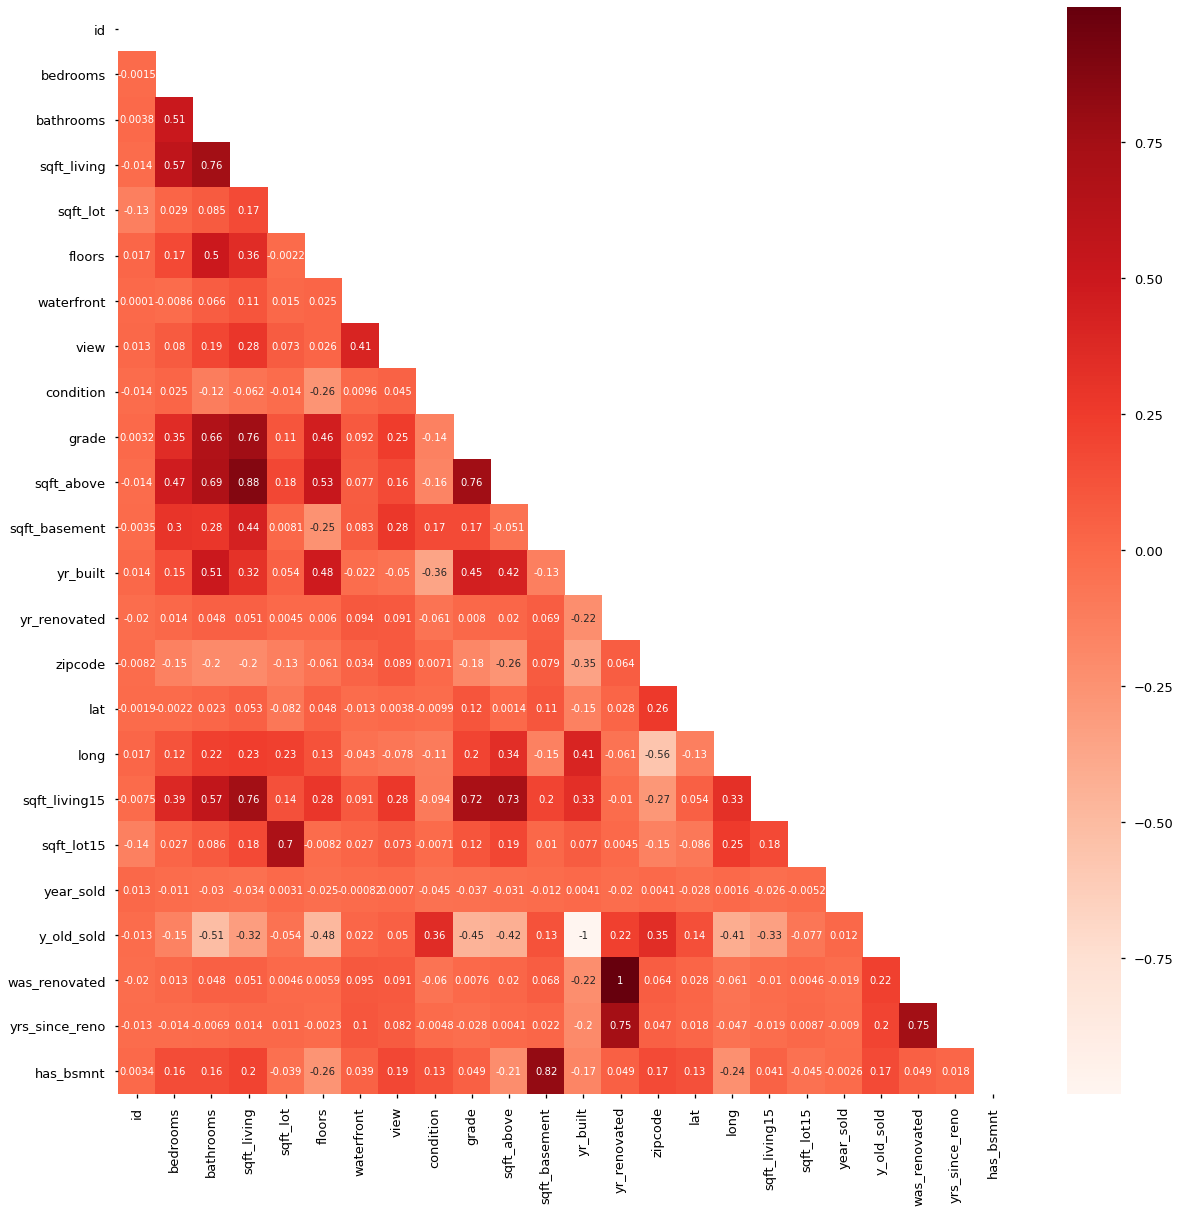

In [54]:
corr_val(df.drop('price',axis=1), figsize=(20,20));

In [55]:
## Correlation results ignoring duplicate values 
## Except for "was_renovated", which shows a perfect relationship to itself

df_corr_results = df.corr().unstack().sort_values(ascending=False).drop_duplicates()

In [56]:
# Show strongest postive and negative correlations
display(df_corr_results[1:11], df_corr_results[-11:-1])

yr_renovated    was_renovated     0.999968
sqft_living     sqft_above        0.876696
has_bsmnt       sqft_basement     0.818269
sqft_living     grade             0.762929
grade           sqft_above        0.758247
sqft_living     bathrooms         0.755270
sqft_living15   sqft_living       0.755066
was_renovated   yrs_since_reno    0.754774
yrs_since_reno  yr_renovated      0.749501
sqft_living15   sqft_above        0.731077
dtype: float64

sqft_living  y_old_sold      -0.319912
y_old_sold   sqft_living15   -0.332739
zipcode      yr_built        -0.348366
condition    yr_built        -0.358921
long         y_old_sold      -0.407716
sqft_above   y_old_sold      -0.424795
y_old_sold   grade           -0.448558
floors       y_old_sold      -0.484020
y_old_sold   bathrooms       -0.508209
zipcode      long            -0.563027
dtype: float64

In [57]:
# Dropping columns to address multicollinearity (over .8)

df.drop(['yr_renovated','sqft_basement','sqft_above'], axis=1, inplace=True)

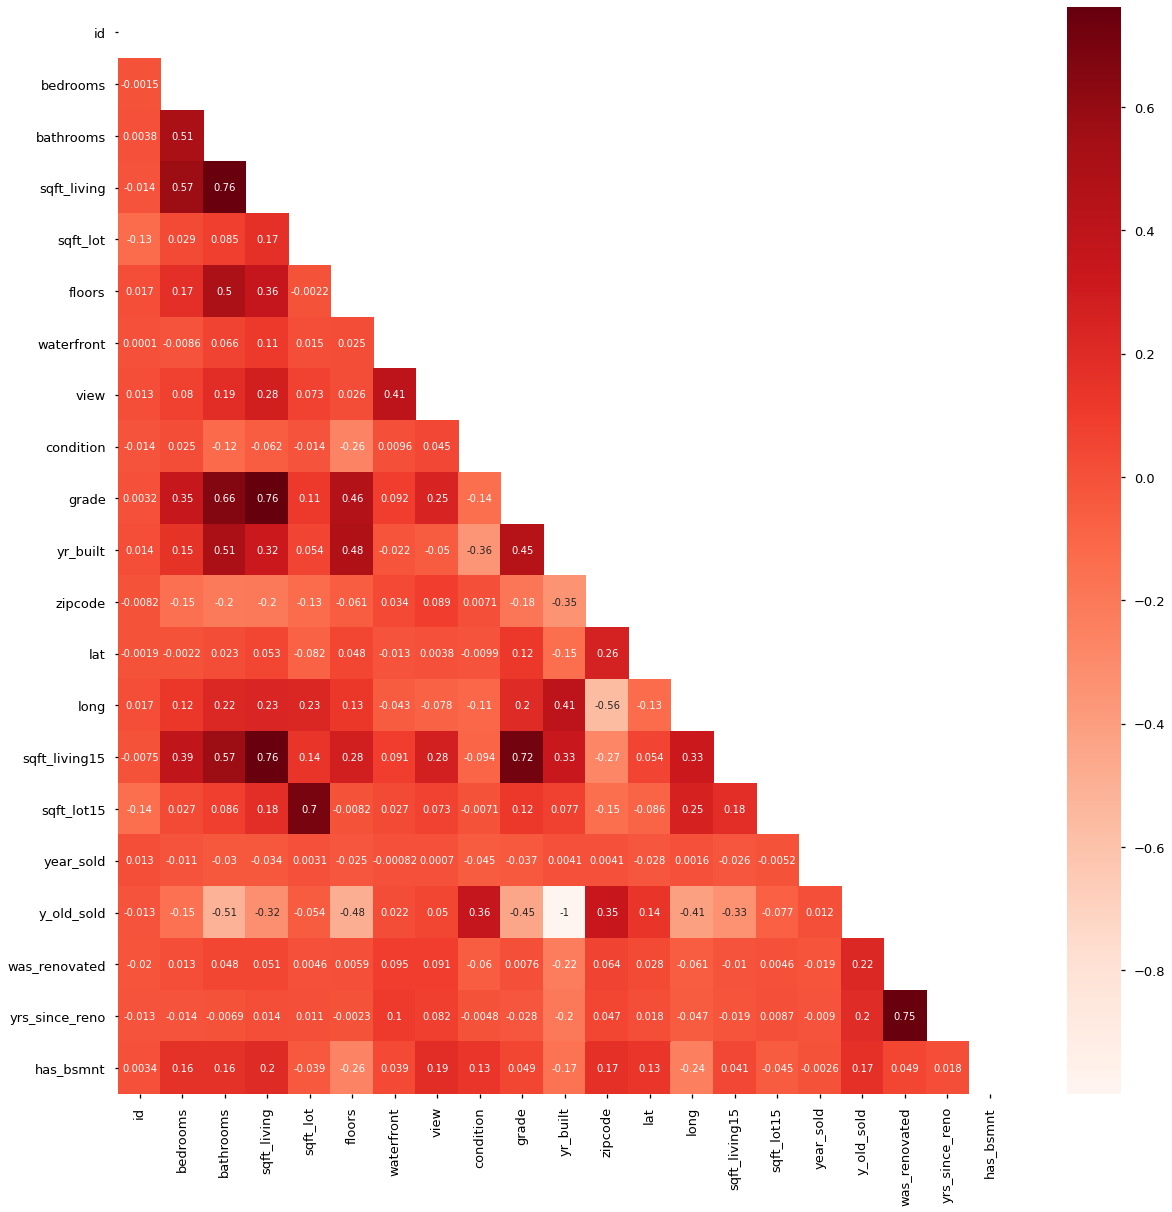

In [58]:
# Rerunning model

corr_val(df.drop('price',axis=1), figsize=(20,20));

In [59]:
# Correlation results ignoring (most) duplicate values
df_corr_results = df.corr().unstack().sort_values(ascending=False).drop_duplicates()

# Show strongest postive and negative correlations
display(df_corr_results[1:11], df_corr_results[-11:-1])

grade           sqft_living      0.762929
sqft_living     bathrooms        0.755270
                sqft_living15    0.755066
yrs_since_reno  was_renovated    0.754774
sqft_living15   grade            0.715745
sqft_living     price            0.703540
sqft_lot        sqft_lot15       0.701875
price           grade            0.666215
grade           bathrooms        0.664191
price           sqft_living15    0.585567
dtype: float64

zipcode      sqft_living15   -0.273903
sqft_living  y_old_sold      -0.319912
y_old_sold   sqft_living15   -0.332739
yr_built     zipcode         -0.348366
condition    yr_built        -0.358921
long         y_old_sold      -0.407716
grade        y_old_sold      -0.448558
y_old_sold   floors          -0.484020
             bathrooms       -0.508209
long         zipcode         -0.563027
dtype: float64

### Interpretation of Correlations

***
**Top 10 Positive Relationships**
>* Nothing too surprising as most of the matches are intuitively related.
>  * E.g. "yr_renovated" and "was_renovated" have a nearly-perfect positive correlation as "was_renovated" is determined by "yr_renovated" in our feature engineering.
>
>
>* Two interesting relationships would be:
>  * The living space (ft^2) and grade
>    * Indicates that a larger house has a higher grade
> * The living space (ft^2) of the 15 nearest houses sold
>   * Indicates a larger area above ground (ft^2)
>    * Perhaps larger houses are more likely to be nearby each other?
***
**Top 10 Negative Relationships**
>* Older houses may have fewer bathrooms
>* Older houses may have fewer floors
>* Older houses have a lower grade
***

# **Statistical Testing**

## One-Way ANOVA

I would assume that the condition of a house would have an impact on the price of a house (who would pay more for a run-down house that would need a lot of repair work?).

I wanted to confirm that the different condition levels would be significant for modeling.

### *Testing `'condition'`*

* H0: The feature "condition" does not have an effect on price.

* Ha: The feature "condition" does  have an effect on price.


In [60]:
## Defining variables for the prices of each value of conditions

condition_1 = df.loc[df['condition'] == 1, 'price']
condition_2 = df.loc[df['condition'] == 2, 'price']
condition_3 = df.loc[df['condition'] == 3, 'price']
condition_4 = df.loc[df['condition'] == 4, 'price']
condition_5 = df.loc[df['condition'] == 5, 'price']

In [61]:
## Running ANOVA test to determine significance

## Define alpha
alpha = .05

## Run test
result = stats.f_oneway(condition_1, condition_2, condition_3, condition_4, condition_5)
f_stat, p_value = result

# Evaluate signficance
if p_value < .05:
    print(f'The condition of a home is statistically significant with a p-value of {p_value}.')
    
else:
     print(f'The condition of a home is not statistically significant with a p-value of {p_value}.')

The condition of a home is statistically significant with a p-value of 6.813536869427384e-24.


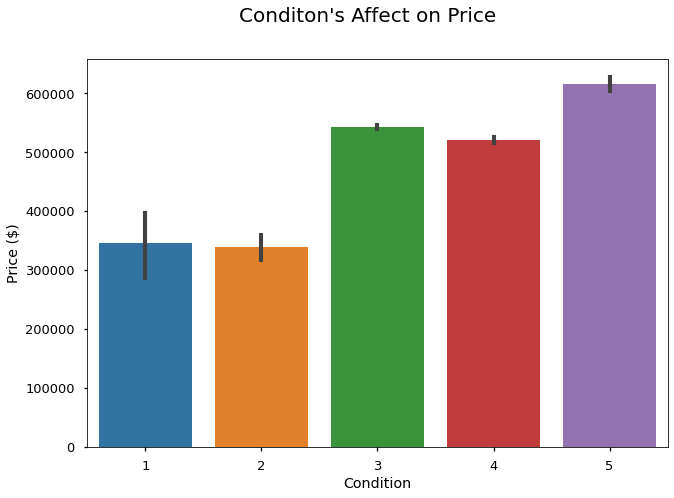

In [62]:
# Show visual of conclusion

sns.barplot(data=df, x= 'condition', y = 'price', ci=68)
plt.suptitle("Conditon's Affect on Price", size = (20))
plt.xlabel('Condition')
plt.ylabel('Price ($)');

#### Interpretation

> The t-test shows that the condition of a house is statistically significant due to the p-value below our alpha of .05.
>
> This means that the quality of a house will have a statistically significant impact on the sell price.

## Two-Sample T-Tests

Again, common sense tells us that waterfront homes would sell for higher prices, but I wanted to confirm that assumption.

### *Testing  `'waterfront'`*

---
**Hypotheses**

>* **H0:** The feature "waterfront" does not have an effect on price.
>
>* **HA:** The feature "waterfront" does  have an effect on price.
>
>* **Alpha** = .05
---

In [63]:
# Set variables to represent whether or not a property is listed as 'waterfront.'

wf_yes = df.loc[df['waterfront'] == 1, 'price']
wf_no = df.loc[df['waterfront'] == 0, 'price']

In [64]:
ttest_review(wf_yes, wf_no)

The feature "waterfront" is statistically significant with a p-value of 2.465038317654299e-299.


2.465038317654299e-299

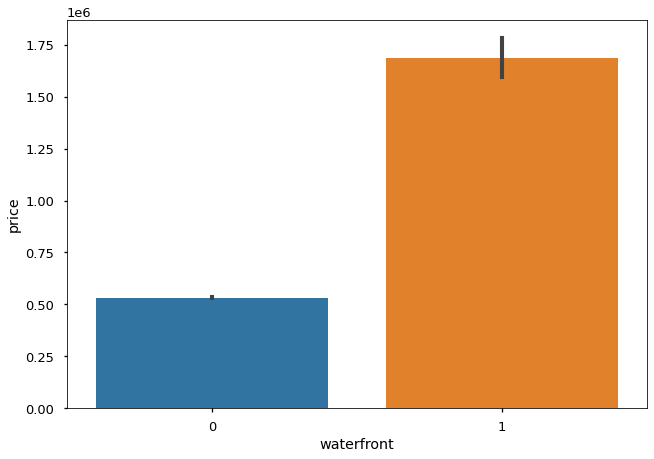

In [65]:
# Show visual of conclusion

sns.barplot(data=df, x= 'waterfront', y = 'price', ci=68);

#### Interpretation

> The t-test shows that waterfront is statistically significant due to the p-value below our alpha of .05.
>
> This means that having a house on the waterfront will have a significant impact on the sell price.

### *Testing `"was_renovated"`*

**Hypotheses**

---
>* **H0:** There is not a statistically significant difference in price in homes with a basement than those without.
>
>* **HA:** There is a statistically significant difference in price in homes with a basement than those without.
>
>* **Alpha** = 0.05
---

In [66]:
reno_y = df.loc[df['was_renovated'] == 1, 'price']
reno_n = df.loc[df['was_renovated'] == 0, 'price']


In [67]:
ttest_review(reno_y, reno_n)

The feature "waterfront" is statistically significant with a p-value of 4.007705820364685e-54.


4.007705820364685e-54

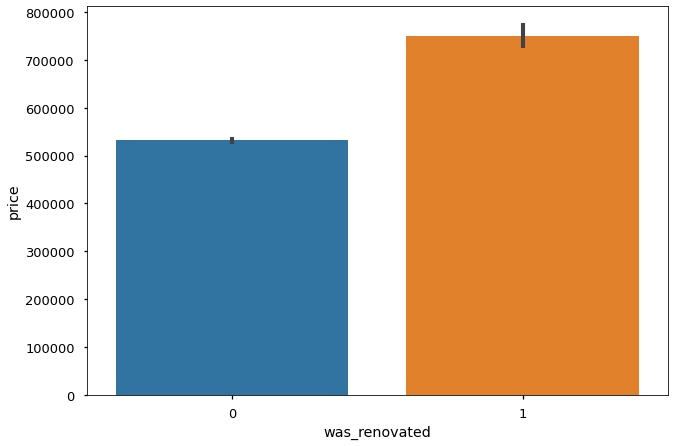

In [68]:
# Show visual of conclusion

sns.barplot(data=df, x= 'was_renovated', y = 'price', ci=68);

#### Interpretation

> The t-test shows that having a basement is statistically significant due to the p-value below our alpha of .05.
>
> This means that having a house with a basement will have a significant impact on the sell price.

# **Inferential Modeling**

## Baseline Model with Raw Data

Creating a baseline model using the raw dataset.

In [69]:
## Reviewing feature names and their datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17290 entries, 0 to 17289
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              17290 non-null  int64  
 1   date            17290 non-null  object 
 2   price           17290 non-null  float64
 3   bedrooms        17290 non-null  int64  
 4   bathrooms       17290 non-null  float64
 5   sqft_living     17290 non-null  int64  
 6   sqft_lot        17290 non-null  int64  
 7   floors          17290 non-null  float64
 8   waterfront      17290 non-null  int64  
 9   view            17290 non-null  int64  
 10  condition       17290 non-null  int64  
 11  grade           17290 non-null  int64  
 12  yr_built        17290 non-null  int64  
 13  zipcode         17290 non-null  int64  
 14  lat             17290 non-null  float64
 15  long            17290 non-null  float64
 16  sqft_living15   17290 non-null  int64  
 17  sqft_lot15      17290 non-null 

price~+y_old_sold+yrs_since_reno+bedrooms+bathrooms+condition+grade+floors+C(was_renovated)+C(has_bsmnt)+C(waterfront)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     2576.
Date:                Thu, 24 Jun 2021   Prob (F-statistic):               0.00
Time:                        12:06:37   Log-Likelihood:            -2.3848e+05
No. Observations:               17290   AIC:                         4.770e+05
Df Residuals:                   17279   BIC:                         4.771e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -1.531e+06   1.81e+04    -84.504      0.000   -1.57e+06    -1.5e+06
C(was_renovated)[T.1]  5.842e+04   1.41e+04      4.130      0.000    3.07e+04    8.62e+04
C(has_bsmnt)[T.1]      3.158e+04   4156.712      7.597      0.000    2.34e+04    3.97e+04
C(waterfront)[T.1]     8.042e+05   2.05e+04     39.232      0.000    7.64e+05    8.44e+05
y_old_sold             4325.6941     85.480     50.605      0.000    4158.144    4493.244
yrs_since_reno        -2511.5735    564.503     -4.449      0.000   -3618.057   -1405.090
bedrooms              -2081.5430   2266.058     -0.919      0.358   -6523.247    2360.161
bathrooms               1.25e+05   3930.644     31.793      0.000    1.17e+05    1.33e+05
condition              2.008e+04   3045.263      6.594      0.000    1.41e+04     2.6e+04
grade                   1.98e+05   2117.430     93.491      0.000    1.94e+05    2.02e+05
floors                 1.586e+04   4400.252      3.604      0.000    7232.686    2.45e+04
==============================================================================
Omnibus:                    15571.873   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1844101.619
Skew:                           3.873   Prob(JB):                         0.00
Kurtosis:                      52.998   Cond. No.                         610.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

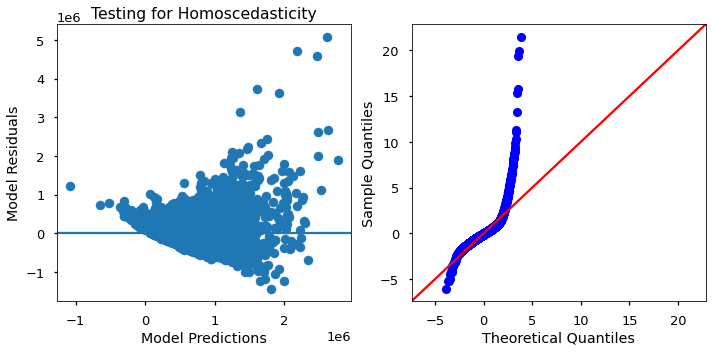

In [70]:
## Establishing the features for inferential modeling

categorical_features = ['was_renovated','has_bsmnt', 'waterfront']

continuous_features = ['y_old_sold','yrs_since_reno', 'bedrooms', 'bathrooms',
                       'condition','grade', 'floors']

model_baseline = create_model(df,continuous_features,categorical_features);

---
**Interpretation:**

>* R^2: ~.6, less than target of .75
>
>* Residual plots show heteroscedasticity
>
>* Q-Q Plot shows non-normal residuals
>
>* Changes: remove outliers and retest
---

## Model without Outliers in 'Price'

What would the model look like if we ignored the outliers?

### Removing Outliers from 'Price' Data

In [71]:
## Remove outliers from price 
idx_outs = find_outliers_z(df['price'])
df_clean = df[~idx_outs].copy()
df_clean

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,y_old_sold,was_renovated,yrs_since_reno,has_bsmnt
0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,1986,98058,47.4388,-122.162,2390,7700,2014,28,0,0.0,0
1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1977,98115,47.6784,-122.285,2370,6283,2014,37,0,0.0,1
2,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,1997,98006,47.5646,-122.129,3710,9685,2014,17,0,0.0,0
3,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,1990,98034,47.6995,-122.228,4050,14226,2015,25,0,0.0,0
4,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2004,98052,47.6647,-122.083,2250,4050,2014,10,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,627300195,20150303T000000,750000.0,5,2.50,3240,9960,1.0,0,1,3,8,1958,98008,47.5858,-122.112,2730,10400,2015,57,0,0.0,1
17286,8819900270,20140520T000000,440000.0,2,1.75,1300,4000,2.0,0,0,3,7,1948,98105,47.6687,-122.288,1350,4013,2014,66,0,0.0,0
17287,3816300095,20140514T000000,310000.0,3,1.00,1050,9876,1.0,0,0,3,7,1953,98028,47.7635,-122.262,1760,9403,2014,61,0,0.0,0
17288,122069107,20141204T000000,427500.0,3,1.50,1900,43186,1.5,0,0,4,7,1971,98038,47.4199,-121.990,2080,108028,2014,43,0,0.0,1


In [72]:
## Remove outliers from bedrooms
idx_outs = find_outliers_z(df_clean['bedrooms'])
df_clean = df_clean[~idx_outs].copy()

df_clean

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,y_old_sold,was_renovated,yrs_since_reno,has_bsmnt
0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,1986,98058,47.4388,-122.162,2390,7700,2014,28,0,0.0,0
1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1977,98115,47.6784,-122.285,2370,6283,2014,37,0,0.0,1
2,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,1997,98006,47.5646,-122.129,3710,9685,2014,17,0,0.0,0
3,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,1990,98034,47.6995,-122.228,4050,14226,2015,25,0,0.0,0
4,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2004,98052,47.6647,-122.083,2250,4050,2014,10,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,627300195,20150303T000000,750000.0,5,2.50,3240,9960,1.0,0,1,3,8,1958,98008,47.5858,-122.112,2730,10400,2015,57,0,0.0,1
17286,8819900270,20140520T000000,440000.0,2,1.75,1300,4000,2.0,0,0,3,7,1948,98105,47.6687,-122.288,1350,4013,2014,66,0,0.0,0
17287,3816300095,20140514T000000,310000.0,3,1.00,1050,9876,1.0,0,0,3,7,1953,98028,47.7635,-122.262,1760,9403,2014,61,0,0.0,0
17288,122069107,20141204T000000,427500.0,3,1.50,1900,43186,1.5,0,0,4,7,1971,98038,47.4199,-121.990,2080,108028,2014,43,0,0.0,1


In [73]:
df_clean.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,y_old_sold,was_renovated,yrs_since_reno,has_bsmnt
count,1.692300e+04,1.692300e+04,16923.000000,16923.000000,16923.00000,1.692300e+04,16923.000000,16923.000000,16923.000000,16923.000000,16923.000000,16923.000000,16923.000000,16923.000000,16923.000000,16923.000000,16923.000000,16923.000000,16923.000000,16923.000000,16923.000000,16923.000000
mean,4.580302e+09,5.068460e+05,3.346038,2.081856,2030.81209,1.502735e+04,1.482302,0.004668,0.210010,3.407375,7.602494,1970.751994,98078.442416,47.558885,-122.213853,1961.790995,12762.476629,2014.323170,43.571175,0.040064,0.746381,0.388170
std,2.875948e+09,2.594154e+05,0.871877,0.731297,831.18918,4.172312e+04,0.536899,0.068167,0.717421,0.649637,1.107905,29.237036,53.534877,0.139363,0.141553,654.638580,27137.875033,0.467701,29.239539,0.196115,4.855077,0.487348
min,1.000102e+06,7.500000e+04,1.000000,0.000000,370.00000,5.720000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,1900.000000,98001.000000,47.155900,-122.519000,399.000000,659.000000,2014.000000,-1.000000,0.000000,-1.000000,0.000000
25%,2.123049e+09,3.200000e+05,3.000000,1.500000,1420.00000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1951.000000,98033.000000,47.466900,-122.330000,1480.000000,5100.000000,2014.000000,18.000000,0.000000,0.000000,0.000000
50%,3.904940e+09,4.464500e+05,3.000000,2.250000,1900.00000,7.587000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1974.000000,98065.000000,47.569600,-122.230000,1830.000000,7597.000000,2014.000000,40.000000,0.000000,0.000000,0.000000
75%,7.309100e+09,6.290000e+05,4.000000,2.500000,2500.00000,1.051150e+04,2.000000,0.000000,0.000000,4.000000,8.000000,1996.000000,98118.000000,47.678750,-122.124000,2330.000000,10004.500000,2015.000000,63.000000,0.000000,0.000000,1.000000
max,9.900000e+09,1.655000e+06,6.000000,6.000000,7350.00000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,12.000000,2015.000000,98199.000000,47.777600,-121.315000,5790.000000,858132.000000,2015.000000,115.000000,1.000000,80.000000,1.000000


price~+y_old_sold+yrs_since_reno+bedrooms+bathrooms+condition+grade+floors+C(was_renovated)+C(has_bsmnt)+C(waterfront)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     2422.
Date:                Thu, 24 Jun 2021   Prob (F-statistic):               0.00
Time:                        12:06:38   Log-Likelihood:            -2.2746e+05
No. Observations:               16923   AIC:                         4.549e+05
Df Residuals:                   16912   BIC:                         4.550e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -1.162e+06   1.35e+04    -86.344      0.000   -1.19e+06   -1.14e+06
C(was_renovated)[T.1]   5.14e+04   1.02e+04      5.021      0.000    3.13e+04    7.15e+04
C(has_bsmnt)[T.1]      4.068e+04   2964.749     13.721      0.000    3.49e+04    4.65e+04
C(waterfront)[T.1]      3.24e+05   1.89e+04     17.130      0.000    2.87e+05    3.61e+05
y_old_sold             3284.2377     62.183     52.816      0.000    3162.353    3406.122
yrs_since_reno        -1913.9577    402.413     -4.756      0.000   -2702.729   -1125.187
bedrooms               5271.9827   1739.192      3.031      0.002    1862.984    8680.981
bathrooms              7.191e+04   2921.530     24.613      0.000    6.62e+04    7.76e+04
condition              2.121e+04   2167.706      9.783      0.000     1.7e+04    2.55e+04
grade                  1.593e+05   1562.805    101.927      0.000    1.56e+05    1.62e+05
floors                 3.852e+04   3166.597     12.164      0.000    3.23e+04    4.47e+04
==============================================================================
Omnibus:                     2820.763   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7575.714
Skew:                           0.908   Prob(JB):                         0.00
Kurtosis:                       5.728   Cond. No.                         784.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

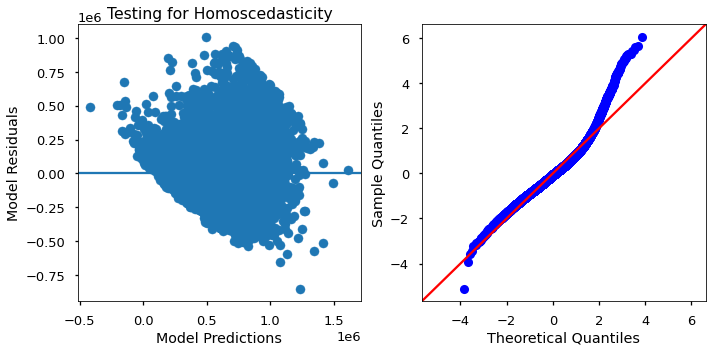

In [74]:
## Redefining updated features and re-running model

categorical_features = ['was_renovated','has_bsmnt', 'waterfront']

continuous_features = ['y_old_sold','yrs_since_reno', 'bedrooms', 'bathrooms',
                       'condition','grade', 'floors']

model_clean = create_model(df_clean,cont=continuous_features,cat=categorical_features);

Interpretation:

* R^2: ~.59, less than target of .75 (performed slightly worse)

* Residual plots show somewhat increased homoscedasticity

* Q-Q Plot shows more normal residuals (vs. earlier plot)

* Changes: add zipcode 

## Model (Clean) - w/ Zip Codes

price~+y_old_sold+yrs_since_reno+bedrooms+bathrooms+condition+grade+floors+C(was_renovated)+C(has_bsmnt)+C(waterfront)+C(zipcode)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     723.0
Date:                Thu, 24 Jun 2021   Prob (F-statistic):               0.00
Time:                        12:06:39   Log-Likelihood:            -2.2246e+05
No. Observations:               16923   AIC:                         4.451e+05
Df Residuals:                   16843   BIC:                         4.457e+05
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -9.082e+05   1.29e+04    -70.617      0.000   -9.33e+05   -8.83e+05
C(was_renovated)[T.1]  5.205e+04   7669.920      6.786      0.000     3.7e+04    6.71e+04
C(has_bsmnt)[T.1]      4194.0254   2410.118      1.740      0.082    -530.059    8918.109
C(waterfront)[T.1]     4.146e+05   1.46e+04     28.492      0.000    3.86e+05    4.43e+05
C(zipcode)[T.98002]    7700.3206   1.24e+04      0.622      0.534   -1.66e+04     3.2e+04
C(zipcode)[T.98003]   -2.942e+04   1.11e+04     -2.651      0.008   -5.12e+04   -7666.780
C(zipcode)[T.98004]    6.095e+05   1.21e+04     50.472      0.000    5.86e+05    6.33e+05
C(zipcode)[T.98005]    2.997e+05    1.3e+04     22.968      0.000    2.74e+05    3.25e+05
C(zipcode)[T.98006]    2.806e+05   9970.638     28.143      0.000    2.61e+05       3e+05
C(zipcode)[T.98007]    2.074e+05   1.35e+04     15.307      0.000    1.81e+05    2.34e+05
C(zipcode)[T.98008]    2.307e+05   1.12e+04     20.617      0.000    2.09e+05    2.53e+05
C(zipcode)[T.98010]    1.156e+05   1.62e+04      7.135      0.000    8.39e+04    1.47e+05
C(zipcode)[T.98011]    1.349e+05   1.22e+04     11.047      0.000    1.11e+05    1.59e+05
C(zipcode)[T.98014]    1.667e+05   1.44e+04     11.542      0.000    1.38e+05    1.95e+05
C(zipcode)[T.98019]    1.188e+05   1.27e+04      9.368      0.000     9.4e+04    1.44e+05
C(zipcode)[T.98022]    3.376e+04   1.17e+04      2.892      0.004    1.09e+04    5.66e+04
C(zipcode)[T.98023]   -3.732e+04   9591.428     -3.891      0.000   -5.61e+04   -1.85e+04
C(zipcode)[T.98024]    2.266e+05   1.73e+04     13.095      0.000    1.93e+05    2.61e+05
C(zipcode)[T.98027]    1.868e+05   1.01e+04     18.439      0.000    1.67e+05    2.07e+05
C(zipcode)[T.98028]    1.311e+05   1.12e+04     11.735      0.000    1.09e+05    1.53e+05
C(zipcode)[T.98029]    1.883e+05   1.09e+04     17.344      0.000    1.67e+05     2.1e+05
C(zipcode)[T.98030]   -7414.8887   1.14e+04     -0.648      0.517   -2.98e+04     1.5e+04
C(zipcode)[T.98031]   -5749.4528   1.12e+04     -0.511      0.609   -2.78e+04    1.63e+04
C(zipcode)[T.98032]   -1.688e+04   1.43e+04     -1.181      0.238   -4.49e+04    1.11e+04
C(zipcode)[T.98033]    3.474e+05   9992.388     34.769      0.000    3.28e+05    3.67e+05
C(zipcode)[T.98034]    1.682e+05   9518.772     17.668      0.000     1.5e+05    1.87e+05
C(zipcode)[T.98038]     5.18e+04   9424.092      5.497      0.000    3.33e+04    7.03e+04
C(zipcode)[T.98039]    8.197e+05   3.19e+04     25.677      0.000    7.57e+05    8.82e+05
C(zipcode)[T.98040]    4.667e+05   1.17e+04     39.877      0.000    4.44e+05     4.9e+05
C(zipcode)[T.98042]    1.474e+04   9540.112      1.545      0.122   -3957.891    3.34e+04
C(zipcode)[T.98045]    1.216e+05   1.19e+04     10.209      0.000    9.83e+04    1.45e+05
C(zipcode)[T.98052]    

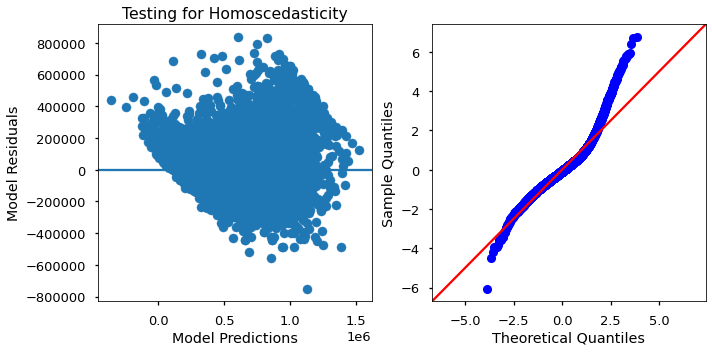

In [75]:
## Adding zip codes as a categorical variable

categorical_features = ['was_renovated','has_bsmnt', 'waterfront', 'zipcode']

continuous_features = ['y_old_sold','yrs_since_reno', 'bedrooms', 'bathrooms',
                       'condition','grade', 'floors']

model_w_zip = create_model(df_clean,continuous_features, categorical_features)

Interpretation:

>* Model is significant with an R-squared value over the threshold of .75 (result: .77)
>
>* Residual plots show somewhat homoscedasticity
>
>* Q-Q Plot shows more normal residuals (vs. earlier plot)
>
>* Changes: remove features with p-values higher than .05 (statistically insignificant values)

price~+y_old_sold+yrs_since_reno+bedrooms+bathrooms+condition+grade+C(was_renovated)+C(waterfront)+C(zipcode)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     741.2
Date:                Thu, 24 Jun 2021   Prob (F-statistic):               0.00
Time:                        12:06:40   Log-Likelihood:            -2.2246e+05
No. Observations:               16923   AIC:                         4.451e+05
Df Residuals:                   16845   BIC:                         4.457e+05
Df Model:                          77                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -9.145e+05   1.26e+04    -72.433      0.000   -9.39e+05    -8.9e+05
C(was_renovated)[T.1]  5.184e+04   7671.429      6.757      0.000    3.68e+04    6.69e+04
C(waterfront)[T.1]     4.146e+05   1.45e+04     28.510      0.000    3.86e+05    4.43e+05
C(zipcode)[T.98002]    6498.2936   1.24e+04      0.525      0.599   -1.78e+04    3.08e+04
C(zipcode)[T.98003]    -2.86e+04   1.11e+04     -2.577      0.010   -5.03e+04   -6842.006
C(zipcode)[T.98004]    6.101e+05   1.21e+04     50.523      0.000    5.86e+05    6.34e+05
C(zipcode)[T.98005]    3.014e+05    1.3e+04     23.107      0.000    2.76e+05    3.27e+05
C(zipcode)[T.98006]    2.818e+05   9965.649     28.272      0.000    2.62e+05    3.01e+05
C(zipcode)[T.98007]    2.073e+05   1.36e+04     15.295      0.000    1.81e+05    2.34e+05
C(zipcode)[T.98008]     2.32e+05   1.12e+04     20.739      0.000     2.1e+05    2.54e+05
C(zipcode)[T.98010]    1.148e+05   1.62e+04      7.083      0.000     8.3e+04    1.47e+05
C(zipcode)[T.98011]     1.35e+05   1.22e+04     11.057      0.000    1.11e+05    1.59e+05
C(zipcode)[T.98014]    1.658e+05   1.44e+04     11.478      0.000    1.37e+05    1.94e+05
C(zipcode)[T.98019]    1.179e+05   1.27e+04      9.296      0.000    9.31e+04    1.43e+05
C(zipcode)[T.98022]    3.311e+04   1.17e+04      2.836      0.005    1.02e+04     5.6e+04
C(zipcode)[T.98023]   -3.635e+04   9589.388     -3.791      0.000   -5.51e+04   -1.76e+04
C(zipcode)[T.98024]    2.261e+05   1.73e+04     13.063      0.000    1.92e+05     2.6e+05
C(zipcode)[T.98027]     1.87e+05   1.01e+04     18.496      0.000    1.67e+05    2.07e+05
C(zipcode)[T.98028]    1.316e+05   1.12e+04     11.782      0.000     1.1e+05    1.54e+05
C(zipcode)[T.98029]    1.866e+05   1.08e+04     17.204      0.000    1.65e+05    2.08e+05
C(zipcode)[T.98030]   -7704.2765   1.14e+04     -0.673      0.501   -3.01e+04    1.47e+04
C(zipcode)[T.98031]   -5857.5752   1.12e+04     -0.521      0.602   -2.79e+04    1.62e+04
C(zipcode)[T.98032]   -1.643e+04   1.43e+04     -1.149      0.250   -4.44e+04    1.16e+04
C(zipcode)[T.98033]    3.475e+05   9994.606     34.769      0.000    3.28e+05    3.67e+05
C(zipcode)[T.98034]    1.693e+05   9515.521     17.787      0.000    1.51e+05    1.88e+05
C(zipcode)[T.98038]    5.042e+04   9417.311      5.353      0.000     3.2e+04    6.89e+04
C(zipcode)[T.98039]    8.205e+05   3.19e+04     25.699      0.000    7.58e+05    8.83e+05
C(zipcode)[T.98040]    4.675e+05   1.17e+04     39.945      0.000    4.45e+05     4.9e+05
C(zipcode)[T.98042]    1.417e+04   9540.489      1.486      0.137   -4526.835    3.29e+04
C(zipcode)[T.98045]    1.213e+05   1.19e+04     10.179      0.000    9.79e+04    1.45e+05
C(zipcode)[T.98052]    2.326e+05   9362.476     24.843      0.000    2.14e+05    2.51e+05
C(zipcode)[T.98053]    

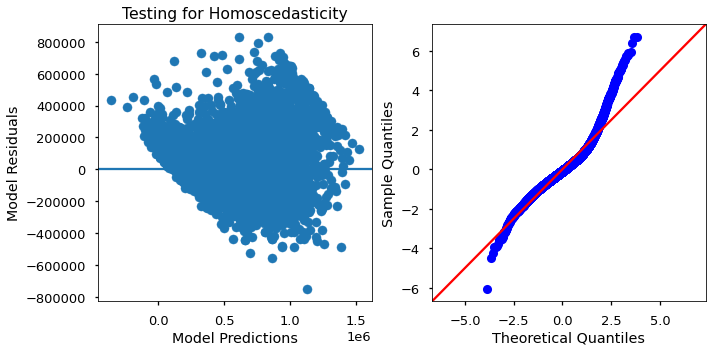

In [76]:
## Re-running model after removing 'has_bsmnt' and 'floors'" due to high p-value
categorical_features = ['was_renovated','waterfront', 'zipcode']

continuous_features = ['y_old_sold','yrs_since_reno', 'bedrooms', 'bathrooms',
                       'condition','grade']

model_clean = create_model(data=df_clean, cont=continuous_features, cat=categorical_features)

In [77]:
# coeff_clean.sort_values(ascending=False)

In [78]:
# # Graphing mode paramnerters to show values
# coeff_clean = model_clean.params.sort_values(ascending=False)
# coeff_clean.plot(kind='barh');

# Recommendations based on Inferential Modeling

If a homeowner is interested in renovating their house, I would recommend the following improvements based on the high coefficients from my model.

* Add bathrooms
* Also consider adding bedrooms
* Use high-quality materials in renovations

While it is outside of the homeowner's ability to change, the zip code for a house's location also has a large impact on the price. A prospective buyer should keep the zip code of the area in mind to help determine the prices of the homes there.

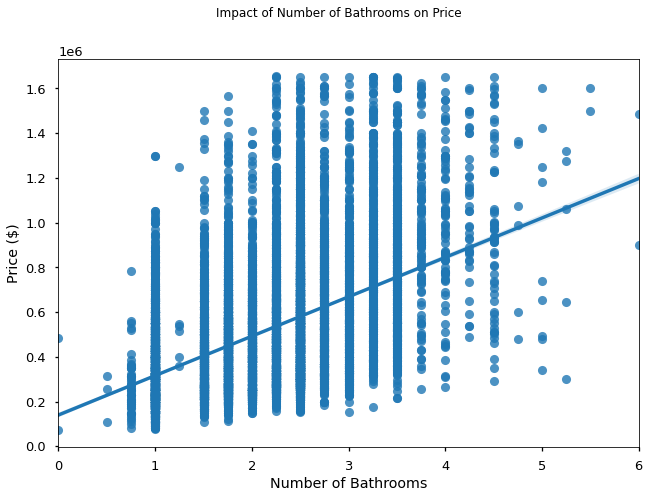

In [79]:
## Visualizing the impact of number of bathrooms on price
sns.regplot(data=df_clean, x="bathrooms", y='price')
plt.suptitle('Impact of Number of Bathrooms on Price')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Price ($)');

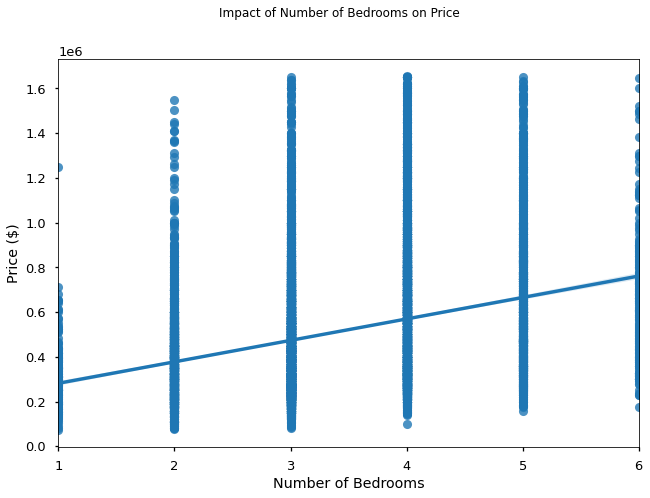

In [80]:
## Visualizing impact of number of bedrooms on price
sns.regplot(data=df_clean, x="bedrooms", y='price')
plt.suptitle('Impact of Number of Bedrooms on Price')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Price ($)');

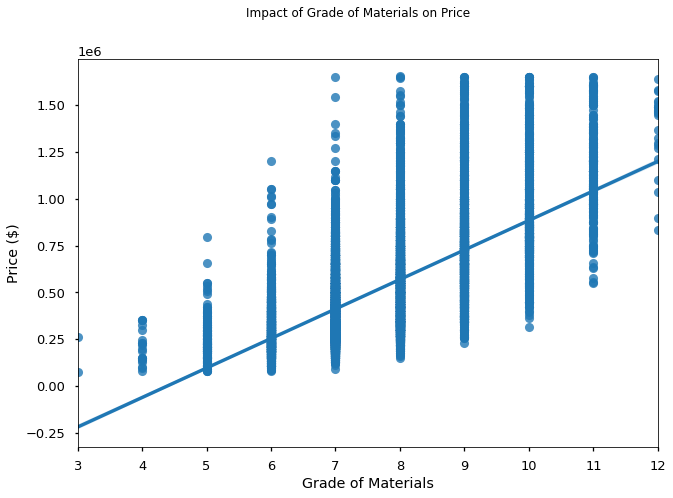

In [81]:
## Visualizing impact of the grade of construction materials on price
sns.regplot(data=df_clean, x="grade", y='price')
plt.suptitle('Impact of Grade of Materials on Price')
plt.xlabel('Grade of Materials')
plt.ylabel('Price ($)');

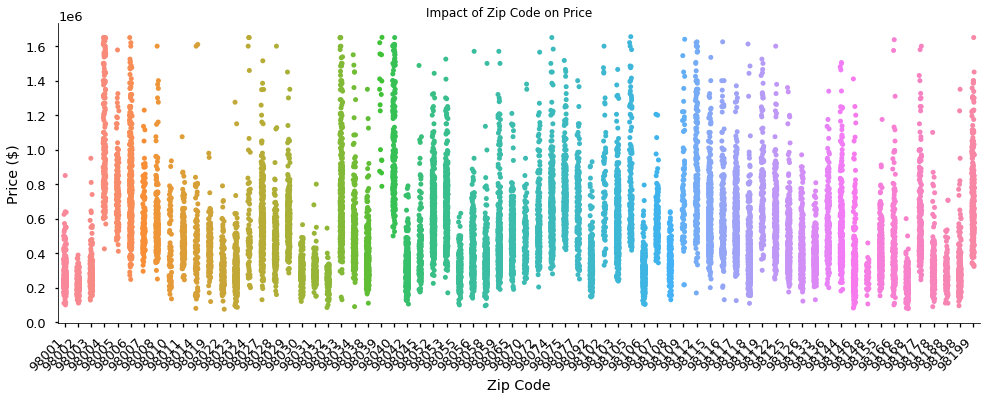

In [82]:
## Representing the diversity of prices based on zip codes

fg = sns.catplot(data=df_clean, x="zipcode", y='price', aspect=2.75, height=5)
fg.ax.set_xticklabels(fg.ax.get_xticklabels(), rotation=45, ha='right')
plt.suptitle('Impact of Zip Code on Price')
plt.xlabel('Zip Code')
plt.ylabel('Price ($)');

# **Model Testing for Predictions**

Now that I have a working model, I want to go ahead and test it to see how well it works. I will split the data in a 75/25 split into two groups; train a model on the 75%; and then compare it against the remaining 25%. 

**My goal is to have a Root Mean Squared Error (RMSE) less than 200,000.**

## ID Features, Target

First, I want to establish the features I want to use in my testing and my target variable (in this case, price).

In [83]:
## Save the features that we used previously - I will use these features 
## to fit my model.

X = df_clean[['was_renovated','waterfront', 'zipcode', 'y_old_sold',
            'yrs_since_reno', 'bedrooms', 'bathrooms', 'condition','grade']].copy()

In [84]:
## Creating the y values by setting them equal to the 'price' values from the dataframe

y = df_clean['price'].copy()

In [85]:
## Verifying the two groups are of equal length

print(X.shape[0] == y.shape[0])

True


## Create Train/Test Split

Now I will split the data into the train/test groups. Then, I will run the first linear regression on the "train" data, then another regression on the "test" data.

In [86]:
## Establishing the train and test data before doing anything else

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=5)

In [87]:
## Using OneHotEncoder to create columns for the categorical variables.

## Create list of categorical variables
cat_feats = ['condition','grade', 'zipcode']

## Create the OHE without "drop='first" as it would throw an error in this case
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse=False)

## Using OHE on our categorical variables for training (NOT testing)
train_ohe = ohe.fit_transform(X_train[cat_feats])
test_ohe = ohe.transform(X_test[cat_feats])

In [92]:
## Getting feature names from ou## Creating dataframes from the results of our fit&transform and transform

feat_col_name = ohe.get_feature_names(cat_feats)

train_ohe_df = pd.DataFrame(train_ohe, columns=feat_col_name, index=X_train.index)

test_ohe_df = pd.DataFrame(test_ohe, columns=feat_col_name, index=X_test.index)#r list of categories


In [93]:
## Creating dataframes from the results of our fit&transform and transform

train_ohe_df = pd.DataFrame(train_ohe, columns=feat_col_name, index=X_train.index)

test_ohe_df = pd.DataFrame(test_ohe, columns=feat_col_name, index=X_test.index)

In [94]:
## Reviewing one of the resulting dataframes
test_ohe_df

,condition_1,condition_2,condition_3,condition_4,condition_5,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,zipcode_98001,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
4033,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6074,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6183,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3013,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9758,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4352,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7198,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15332,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [95]:
## Reviewing the training dataset
X_train

,was_renovated,waterfront,zipcode,y_old_sold,yrs_since_reno,bedrooms,bathrooms,condition,grade
6486,0,0,98032,36,0.0,4,2.25,3,8
6240,0,0,98115,89,0.0,2,1.75,4,7
940,0,0,98058,8,0.0,4,5.50,3,11
3011,0,0,98136,59,0.0,3,1.75,3,8
10378,0,0,98052,31,0.0,3,3.25,3,10
...,...,...,...,...,...,...,...,...,...
758,0,0,98042,23,0.0,5,3.25,3,9
1055,0,0,98115,87,0.0,3,2.25,5,7
5648,0,0,98014,53,0.0,3,1.00,3,6
3117,0,0,98024,75,0.0,3,1.00,3,6


In [96]:
## Concatenating the two training dataframes after OHE
X_train_ohe = pd.concat([X_train.drop(cat_feats, axis=1), train_ohe_df], axis=1)

In [97]:
## Concatenating the two test dataframes after OHE
X_test_ohe = pd.concat([X_test.drop(cat_feats, axis=1), test_ohe_df], axis=1)
X_test_ohe

,was_renovated,waterfront,y_old_sold,yrs_since_reno,bedrooms,bathrooms,condition_1,condition_2,condition_3,condition_4,condition_5,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,zipcode_98001,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
4033,0,0,47,0.0,3,1.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6074,0,0,56,0.0,3,1.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6183,0,0,42,0.0,3,2.50,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3013,0,0,69,0.0,3,1.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9758,0,0,29,0.0,5,2.25,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4352,0,0,60,0.0,3,1.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7198,0,0,21,0.0,3,2.50,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

## Fitting the Model

Now I will create the linear regression model.

In [98]:
## Instantiating the model and fitting it
lr = LinearRegression()

lr.fit(X_train_ohe, y_train)

LinearRegression()

In [99]:
## Checking the R^2 for train and test

train_r = lr.score(X_train_ohe, y_train)
print(f'R-Square value for training data is {round(train_r,3)}.')

test_r = lr.score(X_test_ohe, y_test)
print(f'R-Square value for test data is {round(test_r,3)}.')

## Getting model coefficients
train_coef = pd.Series(lr.coef_, index=X_train_ohe.columns)
train_coef['intercept'] = lr.intercept_

## Displaying resulting features and coefficients
train_coef.sort_values(ascending=False)#.plot(kind='barh');

R-Square value for training data is 0.791.
R-Square value for test data is 0.789.


condition_5    3.065945e+15
condition_4    3.065945e+15
condition_3    3.065945e+15
condition_2    3.065945e+15
condition_1    3.065945e+15
                   ...     
grade_3       -3.367975e+15
grade_7       -3.367975e+15
grade_6       -3.367975e+15
grade_4       -3.367975e+15
grade_5       -3.367975e+15
Length: 92, dtype: float64

In [100]:
## Determining predictions for training data

y_train_pred = lr.predict(X_train_ohe)

## Determining predictions for test data

y_test_pred = lr.predict(X_test_ohe)

## Evaluate Performance

Let's see how it performed against the test dataset!

In [101]:
## Calculating scores for training model

train_mae = metrics.mean_absolute_error(y_train, y_train_pred)
train_mse = metrics.mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

print('Evaluating performance of training data.')
print()
print(f'Mean Absolute Error: {train_mae:,.2f}')
print(f'Mean Squared Error:  {train_mse:,.2f}')
print()
print(f'Root Mean Squared Error: {train_rmse:,.2f}')
train_r = lr.score(X_train_ohe, y_train)
print(f'R-Square value for training data is {round(train_r,2)}.')

Evaluating performance of training data.

Mean Absolute Error: 83,184.52
Mean Squared Error:  13,848,532,695.00

Root Mean Squared Error: 117,679.79
R-Square value for training data is 0.79.


In [102]:
## Calculating scores for test model

test_mae = metrics.mean_absolute_error(y_test, y_test_pred)
test_mse = metrics.mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

print(f'Mean Absolute Error: {test_mae:,.2f}')
print(f'Mean Squared Error: {test_mse:,.2f}')
print()
print(f'Root Mean Squared Error: {test_rmse:,.2f}')
test_r = lr.score(X_test_ohe, y_test)
print(f'R-Square value for test data is {round(test_r,2)}.')

Mean Absolute Error: 84,807.42
Mean Squared Error: 14,948,378,800.01

Root Mean Squared Error: 122,263.56
R-Square value for test data is 0.79.


## Comparing Results

In [103]:
## Calculating difference between RMSE(Training) and RMSE(Test)

print('Our RMSE values for each set:')
print(f'Train RMSE: {train_rmse:,.2f}')
print(f'Test RMSE: {test_rmse:,.2f}')

diff = train_rmse - test_rmse

print()
print(f'The difference in RMSE between our training and test sets is {diff:,.2f}.')

Our RMSE values for each set:
Train RMSE: 117,679.79
Test RMSE: 122,263.56

The difference in RMSE between our training and test sets is -4,583.77.


## Testing Assumptions

In [104]:
## Determining residuals
residuals = (y_test - y_test_pred)
residuals

4033      23041.96875
6074       9783.62500
6183      65636.15625
3013     149509.12500
9758      27055.59375
             ...     
4352     112064.03125
7198     -70832.03125
15332   -132080.28125
1793     -45394.78125
957       83897.09375
Name: price, Length: 4231, dtype: float64

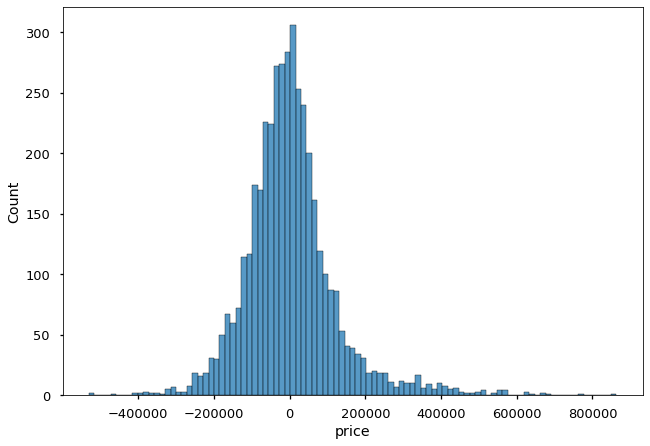

In [105]:
## Plotting to test for normality
sns.histplot(data=residuals);

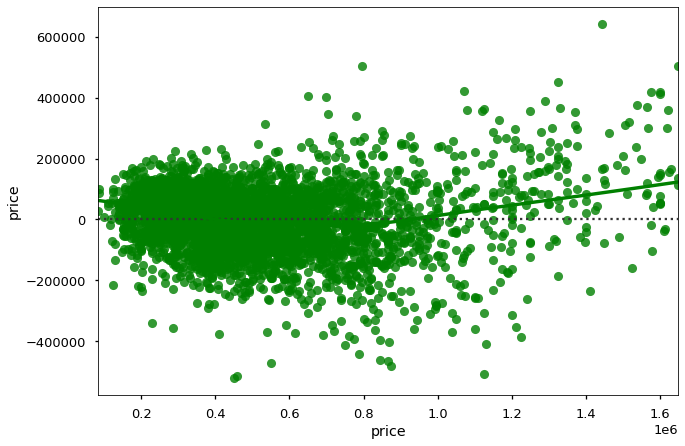

In [106]:
## Checking the homoscedasticity of the new model
sns.residplot(x=y_test, y=residuals, lowess=True, color="g");

### Interpretation of Model Results

The model does a great job of explaining the variance between our selected features, with an r-squared value of .79/1.

The RMSE for both the training and test sets are below our target of 200,000! Additionally, the difference between the two is within an acceptable range.

The assumption tests confirm the assumptions that our residuals would be normally distributed and homoscedastic.

## Recursive Feature Elimination

I have a good model created above, but I'd like to see if changing the features would have an impact for me.

**I will use the Recursive Feature Elimination method with Cross Validation to determine another selection of features.**

In [107]:
## Creating the settings for the selector
selector = RFECV(estimator=lr, step=2, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

In [108]:
## Running it on our training data
selector.fit(X_train_ohe, y_train)

Fitting estimator with 91 features.
Fitting estimator with 89 features.
Fitting estimator with 87 features.
Fitting estimator with 85 features.
Fitting estimator with 83 features.
Fitting estimator with 81 features.
Fitting estimator with 79 features.
Fitting estimator with 77 features.
Fitting estimator with 75 features.
Fitting estimator with 73 features.
Fitting estimator with 71 features.
Fitting estimator with 69 features.
Fitting estimator with 67 features.
Fitting estimator with 65 features.
Fitting estimator with 63 features.
Fitting estimator with 61 features.
Fitting estimator with 59 features.
Fitting estimator with 57 features.
Fitting estimator with 55 features.
Fitting estimator with 53 features.
Fitting estimator with 51 features.
Fitting estimator with 49 features.
Fitting estimator with 47 features.
Fitting estimator with 45 features.
Fitting estimator with 43 features.
Fitting estimator with 41 features.
Fitting estimator with 39 features.
Fitting estimator with 37 fe

RFECV(cv=3, estimator=LinearRegression(), n_jobs=-1,
      scoring='neg_mean_squared_error', step=2, verbose=1)

In [109]:
## Dividing the data into two separate variables for inspection
selected_columns = X_train_ohe.columns[selector.get_support()]
removed_columns = X_train_ohe.columns[~selector.get_support()]

In [110]:
## Inspecting the columns with the greatest impact according to the RSECV method
list(selected_columns.values)

['condition_1',
 'condition_2',
 'condition_3',
 'condition_4',
 'condition_5',
 'grade_3',
 'grade_4',
 'grade_5',
 'grade_6',
 'grade_7',
 'grade_8',
 'grade_9',
 'grade_10']

In [111]:
## Testing the new list of columns

## Instantiating a new regression model
lr_rfe = LinearRegression()

## Fitting the model to the new data
lr_rfe.fit(X_train_ohe[selected_columns], y_train)

# Using the model to create new predictions
y_rfe = lr_rfe.predict(X_train_ohe[selected_columns])

# Determining RMSE for new list of columns and TRAIN data
trainRFE_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_rfe))

print(f'Training Root Mean Squared Error: {trainRFE_rmse:,.2f}')

# Determining RMSE for new list of columns and TEST data
y_pred_rfe = lr_rfe.predict(X_test_ohe[selected_columns])

testRFE_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfe))

print(f'Testing Root Mean Squared Error: {testRFE_rmse:,.2f}')

diff2 = trainRFE_rmse - testRFE_rmse
print()
print(f'The difference in RMSE between our training and test sets is {diff2:,.2f}.')

Training Root Mean Squared Error: 182,158.41
Testing Root Mean Squared Error: 191,360.88

The difference in RMSE between our training and test sets is -9,202.47.


In [112]:
test_rsq = lr_rfe.score(X_test_ohe[selected_columns], y_test)
print(f'R-Square value for testing data after RFECV is {round(test_rsq,2)}.')

R-Square value for testing data after RFECV is 0.48.


### Interpretation of Results of RFEVC

---
**Comparing RMSEs from original model to RFECV:**

* **Pre-RFECV model results:**
   * The R^2 value for both training and testing data was .79 (significant as it is over the .70 threshold).
   * *Our RMSE values for each set:*
        * Train RMSE: 117,679.79
        * Test RMSE: 122,263.56
    * The difference in RMSE between our training and test sets is **-4,583.77**.


 * **Post-RFECV model results:**
     * The R^2 value for the test data is .48 (.31 lower than other model, and far below threshold).
     * *Our RMSE values for each set:*
         * Training Root Mean Squared Error: 182,158.41
         * Testing Root Mean Squared Error: 191,360.88
     * The difference in RMSE between our training and test sets is **-9,202.47**.

---

**Final Analysis of RFE method:** The RFE results produced a large decrease in model perfomance as determined by the lower R^2 and lower RMSE values. I will continue using the first model for future predictions.

---

# **Model Testing - Original Data**

The model produced above was based on data from which we removed any outliers. I am re-running the tests to determine if there is any difference in the results. 

**My goal is to have a Root Mean Squared Error (RMSE) less than 200,000.**

## ID Features, Target

In [113]:
## Saving the features that I used for inferential modeling - I will use these features 
## to fit my model.

X = df[['was_renovated','waterfront', 'zipcode', 'y_old_sold',
            'yrs_since_reno', 'bedrooms', 'bathrooms', 'condition','grade']].copy()

In [114]:
## Creating the y values by setting them equal to the 'price' values from the dataframe

y = df['price'].copy()

In [115]:
## Verifying the two groups are of equal length

print(X.shape[0] == y.shape[0])

True


## Create Train/Test Split

Now I will split the data into the train/test groups. Then, I will run the first linear regression on the "train" data, then another regression on the "test" data.

In [116]:
## Establishing the train and test data before doing anything else

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=5)

In [117]:
## Using OneHotEncoder to create columns for the categorical variables.

## Create list of categorical variables
cat_feats = ['condition','grade', 'zipcode']

## Create the OHE without "drop='first" as it would throw an error in this case
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse=False)

## Using OHE on our categorical variables for training (NOT testing)
train_ohe = ohe.fit_transform(X_train[cat_feats])
test_ohe = ohe.transform(X_test[cat_feats])

In [118]:
## Getting feature names from our list of categories
feat_col_name = ohe.get_feature_names(cat_feats)

In [119]:
## Creating dataframes from the results of our fit&transform and transform

train_ohe_df = pd.DataFrame(train_ohe, columns=feat_col_name, index=X_train.index)

test_ohe_df = pd.DataFrame(test_ohe, columns=feat_col_name, index=X_test.index)

In [120]:
## Reviewing one of the resulting dataframes
test_ohe_df

,condition_1,condition_2,condition_3,condition_4,condition_5,grade_1,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,zipcode_98001,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
3701,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3580,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3903,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12786,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1694,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3604,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15993,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12954,0.0,0.0,1.0,0.0,0.0,0.0,0.0,

In [121]:
X_train

,was_renovated,waterfront,zipcode,y_old_sold,yrs_since_reno,bedrooms,bathrooms,condition,grade
14038,0,0,98058,40,0.0,4,2.25,3,7
2202,0,0,98052,46,0.0,4,3.00,4,8
325,0,0,98030,2,0.0,4,2.50,3,8
9061,0,0,98168,58,0.0,3,1.00,3,7
251,0,0,98119,65,0.0,2,1.50,3,7
...,...,...,...,...,...,...,...,...,...
740,0,0,98133,67,0.0,3,1.00,3,6
1032,0,0,98027,45,0.0,3,1.00,3,7
5520,0,0,98031,32,0.0,3,1.75,3,7
3046,0,0,98030,51,0.0,3,1.75,4,7


In [122]:
## Combining the training dataframes after performing OHE
X_train_ohe = pd.concat([X_train.drop(cat_feats, axis=1), train_ohe_df], axis=1)

In [123]:
## Combining the testing dataframes after performing OHE
X_test_ohe = pd.concat([X_test.drop(cat_feats, axis=1), test_ohe_df], axis=1)
X_test_ohe

,was_renovated,waterfront,y_old_sold,yrs_since_reno,bedrooms,bathrooms,condition_1,condition_2,condition_3,condition_4,condition_5,grade_1,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,zipcode_98001,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
3701,0,0,8,0.0,3,2.50,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3580,0,0,21,0.0,3,2.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3903,0,1,34,0.0,4,4.25,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12786,0,0,60,0.0,3,1.50,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1694,0,0,68,0.0,4,1.75,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3604,0,0,14,0.0,3,3.50,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15993,0,0,23,0.0,4,2.50,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

## Fitting the Model

In [124]:
## Instantiating the model and fitting it
lr = LinearRegression()

lr.fit(X_train_ohe, y_train)

LinearRegression()

In [125]:
## Checking the R^2 for train and test

train_r = lr.score(X_train_ohe, y_train)
print(f'R-Square value for training data is {round(train_r,3)}.')

test_r = lr.score(X_test_ohe, y_test)
print(f'R-Square value for test data is {round(test_r,3)}.')

## Getting model coefficients
train_coef = pd.Series(lr.coef_, index=X_train_ohe.columns)
train_coef['intercept'] = lr.intercept_

## Displaying resulting features and coefficients
train_coef.sort_values(ascending=False)[:11]#.plot(kind='barh');

R-Square value for training data is 0.788.
R-Square value for test data is 0.79.


grade_13    1.404118e+14
grade_12    1.404118e+14
grade_11    1.404118e+14
grade_10    1.404118e+14
grade_9     1.404118e+14
grade_8     1.404118e+14
grade_3     1.404118e+14
grade_7     1.404118e+14
grade_1     1.404118e+14
grade_4     1.404118e+14
grade_6     1.404118e+14
dtype: float64

In [126]:
## Determining predictions for training data

y_train_pred = lr.predict(X_train_ohe)


## Determining predictions for test data

y_test_pred = lr.predict(X_test_ohe)


## Evaluate Performance

In [127]:
## Calculating scores for training model

train_mae = metrics.mean_absolute_error(y_train, y_train_pred)
train_mse = metrics.mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

print('Evaluating performance of training data.')
print()
print(f'Mean Absolute Error: {train_mae:,.2f}')
print(f'Mean Squared Error:  {train_mse:,.2f}')
print()
print(f'Root Mean Squared Error: {train_rmse:,.2f}')
train_r = lr.score(X_train_ohe, y_train)
print(f'R-Square value for training data is {round(train_r,2)}.')

Evaluating performance of training data.

Mean Absolute Error: 100,712.64
Mean Squared Error:  28,849,162,106.62

Root Mean Squared Error: 169,850.41
R-Square value for training data is 0.79.


In [128]:
## Calculating scores for test model

test_mae = metrics.mean_absolute_error(y_test, y_test_pred)
test_mse = metrics.mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

print(f'Mean Absolute Error: {test_mae:,.2f}')
print(f'Mean Squared Error: {test_mse:,.2f}')
print()
print(f'Root Mean Squared Error: {test_rmse:,.2f}')
test_r = lr.score(X_test_ohe, y_test)
print(f'R-Square value for test data is {round(test_r,2)}.')

Mean Absolute Error: 101,914.46
Mean Squared Error: 31,243,540,022.14

Root Mean Squared Error: 176,758.42
R-Square value for test data is 0.79.


## Comparing Results

In [129]:
## Calculating difference between RMSE(Training) and RMSE(Test)

print('Our RMSE values for each set:')
print(f'Train RMSE: {train_rmse:,.2f}')
print(f'Test RMSE: {test_rmse:,.2f}')

diff = train_rmse - test_rmse

print()
print(f'The difference in RMSE between our training and test sets is {diff:,.2f}.')

Our RMSE values for each set:
Train RMSE: 169,850.41
Test RMSE: 176,758.42

The difference in RMSE between our training and test sets is -6,908.01.


## Testing Assumptions

In [130]:
## Determining residuals
residuals = (y_test - y_test_pred)
residuals

3701    -1.906941e+05
3580     3.038108e+04
3903     1.282617e+06
12786   -6.472320e+03
1694     9.917154e+04
             ...     
3604    -2.094837e+05
15993   -4.126162e+04
12954    5.035755e+04
13200   -2.724516e+04
14995   -5.624730e+04
Name: price, Length: 4323, dtype: float64

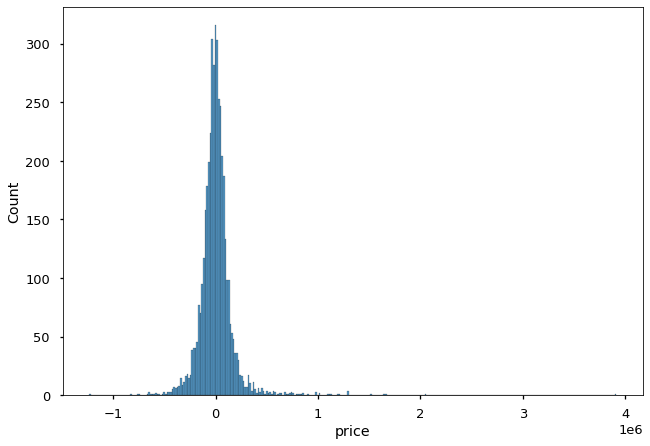

In [131]:
## Plotting to test for normality
sns.histplot(data=residuals);

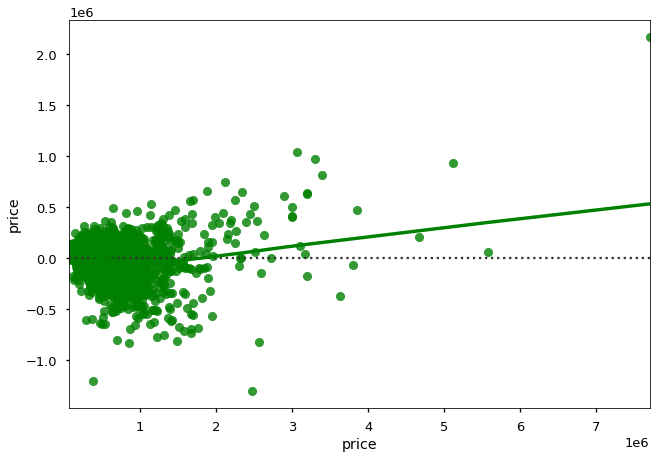

In [132]:
## Checking the homoscedasticity of the new model
sns.residplot(x=y_test, y=residuals, lowess=True, color="g");

### Interpretation of Model Results

The model continues to do a job of explaining the variance between our selected features, with an r-squared value of .79/1.

The RMSE for both the training and test sets are below our target of 200,000, but higher than our model without the outliers. The difference between the two RMSEs did increase, indicating area for improvement.

The assumption tests confirm the assumptions that our residuals would be normally distributed and homoscedastic.

## Recursive Feature Elimination

The model using the original data performed worse in terms of RMSE, but maintained the R^2 value of .79.

Let's see if the RFECV has any impact this time.

In [133]:
## Creating the settings for the selector
selector = RFECV(estimator=lr, step=2, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

In [134]:
## Running it on our training data
selector.fit(X_train_ohe, y_train)

Fitting estimator with 93 features.
Fitting estimator with 91 features.
Fitting estimator with 89 features.
Fitting estimator with 87 features.
Fitting estimator with 85 features.
Fitting estimator with 83 features.
Fitting estimator with 81 features.
Fitting estimator with 79 features.
Fitting estimator with 77 features.
Fitting estimator with 75 features.
Fitting estimator with 73 features.
Fitting estimator with 71 features.
Fitting estimator with 69 features.
Fitting estimator with 67 features.
Fitting estimator with 65 features.
Fitting estimator with 63 features.
Fitting estimator with 61 features.
Fitting estimator with 59 features.
Fitting estimator with 57 features.
Fitting estimator with 55 features.
Fitting estimator with 53 features.
Fitting estimator with 51 features.
Fitting estimator with 49 features.
Fitting estimator with 47 features.
Fitting estimator with 45 features.
Fitting estimator with 43 features.
Fitting estimator with 41 features.
Fitting estimator with 39 fe

RFECV(cv=3, estimator=LinearRegression(), n_jobs=-1,
      scoring='neg_mean_squared_error', step=2, verbose=1)

In [135]:
## Dividing the data into two separate variables for inspection
selected_columns = X_train_ohe.columns[selector.get_support()]
removed_columns = X_train_ohe.columns[~selector.get_support()]

In [136]:
## Inspecting the columns with the greatest impact according to the RSECV method
list(selected_columns.values)

['grade_1',
 'grade_6',
 'grade_7',
 'grade_8',
 'grade_9',
 'grade_10',
 'grade_11',
 'grade_12',
 'grade_13']

In [137]:
## Testing the new list of columns

## Instantiating a new regression model
lr_rfe = LinearRegression()

## Fitting the model to the new data
lr_rfe.fit(X_train_ohe[selected_columns], y_train)

# Using the model to create new predictions
y_rfe = lr_rfe.predict(X_train_ohe[selected_columns])

# Determining RMSE for new list of columns and TRAIN data
trainRFE_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_rfe))

print(f'Training Root Mean Squared Error: {trainRFE_rmse:,.2f}')

# Determining RMSE for new list of columns and TEST data
y_pred_rfe = lr_rfe.predict(X_test_ohe[selected_columns])

testRFE_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfe))

print(f'Testing Root Mean Squared Error: {testRFE_rmse:,.2f}')

diff2 = trainRFE_rmse - testRFE_rmse
print()
print(f'The difference in RMSE between our training and test sets is {diff2:,.2f}.')

Training Root Mean Squared Error: 255,961.96
Testing Root Mean Squared Error: 258,659.15

The difference in RMSE between our training and test sets is -2,697.18.


In [138]:
test_rsq = lr_rfe.score(X_test_ohe[selected_columns], y_test)
print(f'R-Square value for testing data after RFECV is {round(test_rsq,2)}.')

R-Square value for testing data after RFECV is 0.55.


---
**Comparing RMSEs from original to RFECV:**

* **Pre-RFECV model results:**
   * The R^2 value for both training and testing data was .79 (significant as it is over the .70 threshold).
   * *Our RMSE values for each set:*
        * Train RMSE: 117,679.79
        * Test RMSE: 122,263.56
    * The difference in RMSE between our training and test sets is **-4,583.77**.


 * **Post-RFECV model results:**
     * The R^2 value for the test data is .48 (.31 lower than other model, and far below threshold).
     * *Our RMSE values for each set:*
         * Training Root Mean Squared Error: 182,158.41
         * Testing Root Mean Squared Error: 191,360.88
     * The difference in RMSE between our training and test sets is **-9,202.47**.

---

**Final Analysis of RFE method:** The RFE results produced a large decrease in model perfomance as determined by the lower R^2 and lower RMSE values. I will continue with the first model for future predictions.

---

# Pickling the Model for Reuse

In [139]:
## Setting coefficients and target
X = df[['was_renovated','waterfront', 'zipcode', 'y_old_sold',
            'yrs_since_reno', 'bedrooms', 'bathrooms', 'condition','grade']].copy()
y = df['price'].copy()

In [140]:
## Create list of categorical variables
cat_feats = ['condition','grade', 'zipcode']

## Create the OHE without "drop='first" as it would throw an error in this case
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse=False)

## Using OHE on our categorical variables for training (NOT testing)
final_ohe = ohe.fit_transform(X[cat_feats])

In [141]:
## Getting feature names from our list of categories
feat_col_name = ohe.get_feature_names(cat_feats)

In [142]:
## Creating DF of final results
final_ohe_df1 = pd.DataFrame(final_ohe, columns=feat_col_name, index=X.index)

In [143]:
final_ohe_df = pd.concat([X.drop(cat_feats, axis=1), final_ohe_df1], axis=1)

In [144]:
lr_final = LinearRegression()

lr_final = lr_final.fit(final_ohe_df, y)

In [145]:
final_pred = lr_final.predict(final_ohe_df)

In [146]:
display(final_pred)

array([ 392072.25,  805538.5 , 1301535.5 , ...,  304438.25,  259248.75,
        371298.75])

In [147]:
import pickle


pickle_out = open("final_model.pickle","wb")
pickle.dump(lr_final, pickle_out)
pickle_out.close()

In [148]:
final_ohe_df

,was_renovated,waterfront,y_old_sold,yrs_since_reno,bedrooms,bathrooms,condition_1,condition_2,condition_3,condition_4,condition_5,grade_1,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,zipcode_98001,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,0,0,28,0.0,4,2.25,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,37,0.0,5,3.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,17,0.0,4,2.50,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,25,0.0,3,3.50,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,10,0.0,3,2.50,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,0,0,57,0.0,5,2.50,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17286,0,0,66,0.0,2,1.75,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0